# Series analysis


Analysis updates:
- retrieve calls rejected only because VAF<0.01 (bcbio lower acceptable threshold) for Mutect2, Strelka2 and Vardict
- correct for germline mutations using GATK haplotype calls
- get PR curves for sinvict by encoding the 6 files as thresholds. Assumption: linear filters
- plotting: PR curves stops at 10e-2 on the left
- ground truths:

    1) Consensus: build using
        majority of 5/8 callers for SNV and 3/5 callers for INDELS


    2) Ranked mutations: metascore built using
        weigthed sum of normalised scores between 0 and 1 for each caller
        with weigths = inversially proportional to number of calls made by caller (if a caller calls few mutations higher weight, it many calls low weight)
        threshold = 1/ncallers
        interpretation: if 1 caller is sure (score = 1) of calling this position, add it to GT
        interpretation: if 2 callers are quite sure of calling this position (score > 0,5 each), add it to GT
        
- integrate VAF approx

    1) mixture with VAF instead of tumor burden
    
    2) correct for mutations non present in diluted samples (vaf = 0)
    
    3) pool patients together using VAF

In [1]:
# Imports

%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from benchmark.table import *
from benchmark.metrics import *
from benchmark.calltable import *
from benchmark.calltableseries import *
from benchmark.groundtruth import *
from benchmark.metricsseries import *
#from utils.venn import venn6, get_labels

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)
print(config.methods)

paper
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'smurf', 'varnet', 'abemus', 'sinvict']


In [3]:
# Chomosome

mixtureids =  ['CRC-986_100215-CW-T_CRC-986_300316-CW-T', 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T', 'CRC-123_310715-CW-T_CRC-123_121115-CW-T', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T']
mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
#mixtureid = 'CRC-123_310715-CW-T_CRC-123_121115-CW-T'
#mixtureid = 'BRA-412_240820-CW-T_BRA-412_060220-CW-T'
reload = False
save = False
fixedvars=['coverage', 'ctdna']
filterparam = 'all'

markers = ['o', '^', 'X']
linestyles = ['-', '-', '-']
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}

muttypes = ['snv', 'indel']
metrics = ['auprc', 'precision', 'recall']

chrom = 'all'

# INDELS: patient 986 = 96, patient 123 = 357, patient 1014 = 277 (≥ 4/6 callers without SMURF)

# Part I: (1) Load/Generate call tables, (2) Generate Ground truths and (3) Compute/Save metrics per patient

In [5]:
fixedvar = 'coverage'
for fixedvar in fixedvars:
    if fixedvar == 'coverage':
        seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
        xaxis = 'tumor burden'
    elif fixedvar == 'ctdna':
        seriesorder = [(70, 0), (70, 80), (70, 180)]
        xaxis = 'coverage'
    #for mixtureid in mixtureids:
    #mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
    print('############# {} ############'.format(mixtureid))
    if mixtureid ==  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T':
        chroms = [str(c) for c in range(1,23) if c != 2 and c!=6 and c !=17 and c!=19 and c!=20 and c!=21]
        #chroms = [str(c) for c in range(1,9) if c != 2 and c!=6]
    elif mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
        chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=8 and c!=20 and c!=21 and c!=22] 
    else:
        chroms = [str(c) for c in range(1,23) if c !=6 and c!=19 and c!=20]  # c !=1 and c!= 2 and
    calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
    aux_all = []
    calltable_snv, aux = get_calltableseries(config, mixtureid, chroms, muttype='snv', filterparam=filterparam, reload=reload, save=save)
    calltable_indel, aux = get_calltableseries(config, mixtureid, chroms, muttype='indel', filterparam=filterparam, reload=reload, save=save)
    calltable_snp, aux = get_calltableseries(config, mixtureid, chroms, muttype='snp', filterparam=filterparam, reload=reload, save=save)
    print(calltable_snv.shape, calltable_indel.shape, calltable_snp.shape)
    print(aux)
    plasmasample = '_'.join(mixtureid.split('_')[:2])
    print(plasmasample)
    healthysample = '_'.join(mixtureid.split('_')[2:])
    print(healthysample)
    calltables['snv'].append(calltable_snv)
    calltables['indel'].append(calltable_indel)
    calltables['snp'].append(calltable_snp)
    calltables['sampleid'] = mixtureid 
    calltables['tf'] = np.unique([cn.split('_')[0] for cn in list(calltable_snv.columns)])[:-5].astype(float)
    calltables['snv'] = pd.concat(calltables['snv'])
    calltables['indel'] = pd.concat(calltables['indel'])
    calltables['snp'] = pd.concat(calltables['snp'])
    dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
    #for muttype in muttypes:
    muttype = 'snv'
    refsample = 'undiluted'
    if muttype == 'snv':
        gtm = 5
    else:  # elif muttype == 'indel':
        gtm = 4
    print(max(aux['tf']))
    #if mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T' and muttype == 'snv':
    #    gtm = 3
    #    refsample = 'tissue'
    #    #calltablesseries  = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method='tissue', muttype=muttype,
    #    #                                    matchedtissuepath=os.path.join('data', 'matchedtissue', 'NCC_CRC-986_100215-T1W', 'calls', 'NCC_CRC-986_100215-T1W_snv_calls_PASS_exome.csv'))
    #    calltablesseries  = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method='tissue', muttype=muttype,
    #                                        matchedtissuepath=os.path.join('data', 'matchedtissue_ultradeep', '986_100215_T1-E', 'calls', '986_100215_T1-E_snv_calls_all.csv'))
    #if mixtureid !=  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    #calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype,
    #                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'abemus', 'sinvict'])
    #else:
    calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                            matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])
    results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                     refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_recall_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='recall', ground_truth_method=gtm,
    #                                       refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='precision', ground_truth_method=gtm,
    #                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_maxf1_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxf1', ground_truth_method=gtm,
    #                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_maxrecallatlast0_05precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_03precision', ground_truth_method=gtm,
    #                                  refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_maxrecallatlast0_05precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_04precision', ground_truth_method=gtm,
    #                                  refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    results_maxrecallatlast0_03precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_03precision', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_maxf1recall_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxf1recall', ground_truth_method=gtm,
    #                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #results_maxf1precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxf1precision', ground_truth_method=gtm,
    #                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
    #figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
    #                    refsample=refsample, muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=save)

############# CRC-986_100215-CW-T_CRC-986_300316-CW-T ############
mixture ['data', 'mixtures']
['3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
mixture ['data', 'mixtures']
data/mixtures/mixtures_chr3/mixtures_chr3_CRC-986_100215-CW-T_CRC-986_300316-CW-T


FileNotFoundError: [Errno 2] No such file or directory: 'data/mixtures/mixtures_chr3/mixtures_chr3_CRC-986_100215-CW-T_CRC-986_300316-CW-T'

['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
test
41.90_freebayes      2642
41.90_mutect2         801
41.90_strelka2      43313
41.90_vardict      154339
41.90_varscan        7539
41.90_varnet           44
41.90_abemus         4621
41.90_sinvict        4918
dtype: object
False    962139
True        206
Name: truth, dtype: int64
41.90_freebayes    161
41.90_mutect2      131
41.90_strelka2     193
41.90_vardict      200
41.90_varscan      189
41.90_smurf         64
41.90_varnet        43
41.90_abemus        73
41.90_sinvict      158
dtype: object
mixture_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
41.90
41.90_freebayes_score
is present
41.90_mutect2_score
is present
41.90_strelka2_score
is present
41.90_vardict_score
is present
41.90_varscan_score
is present
41.90_smurf_score
is present
41.90_varnet_score
is present
41.90_abemus_score
is present
41.90_

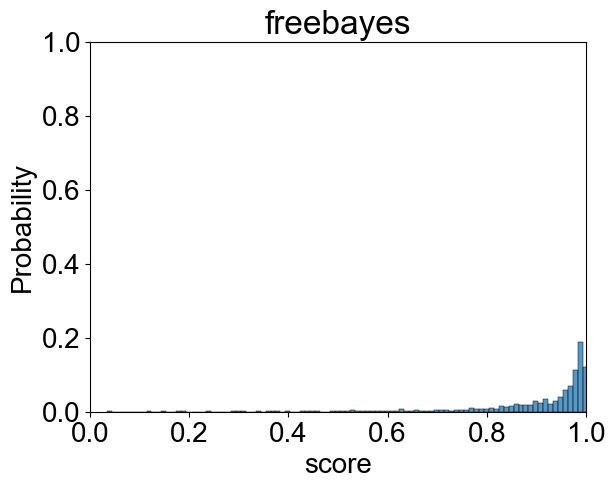

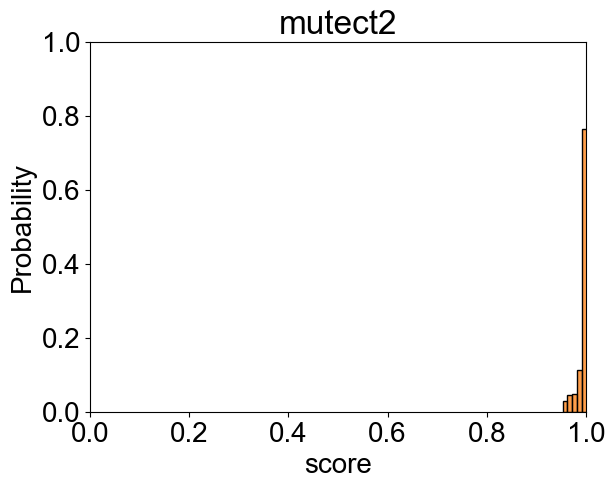

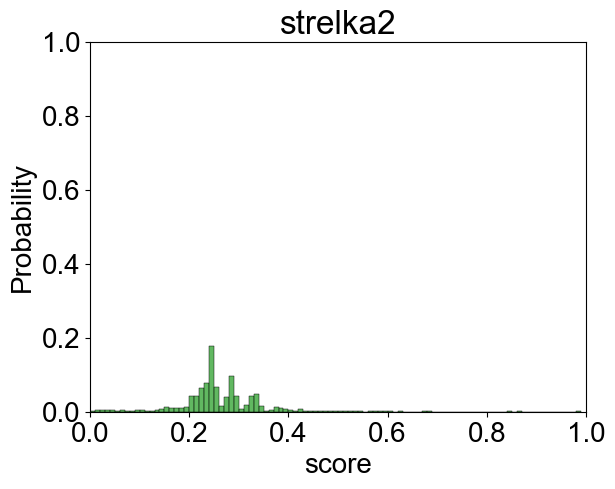

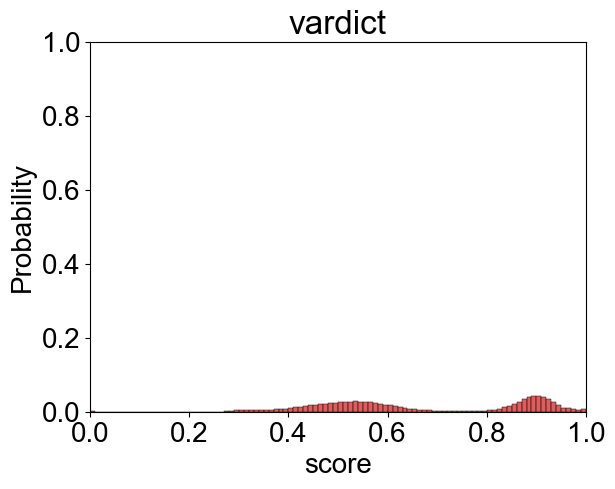

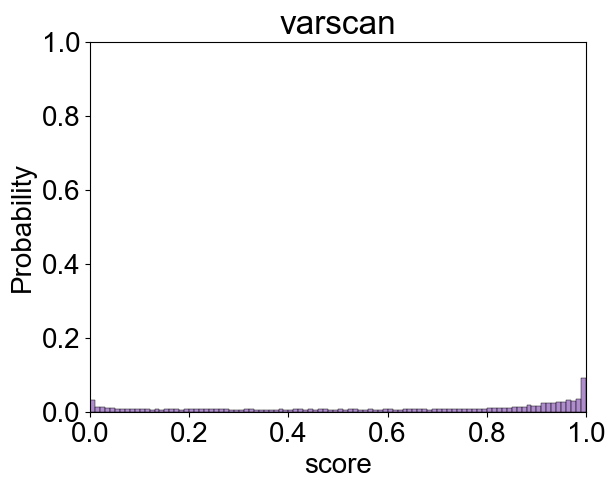

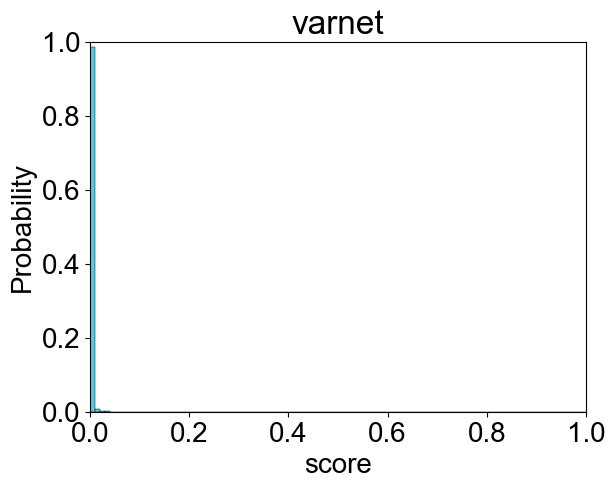

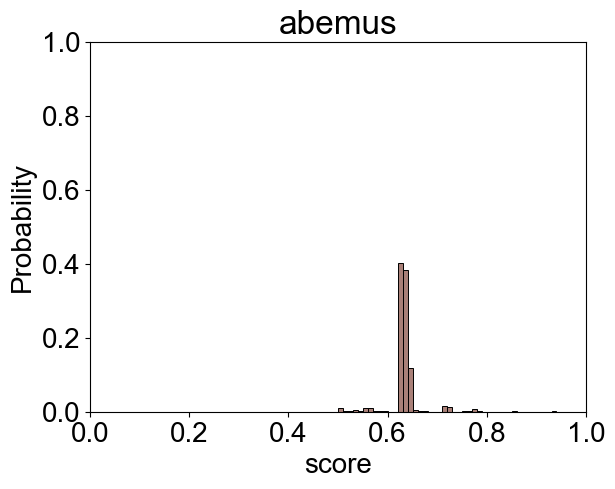

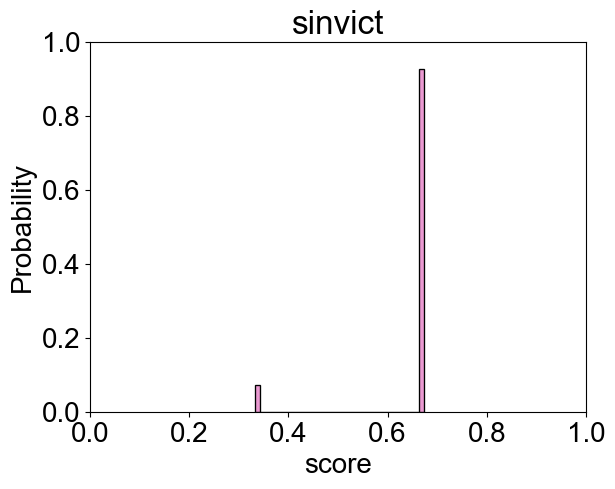

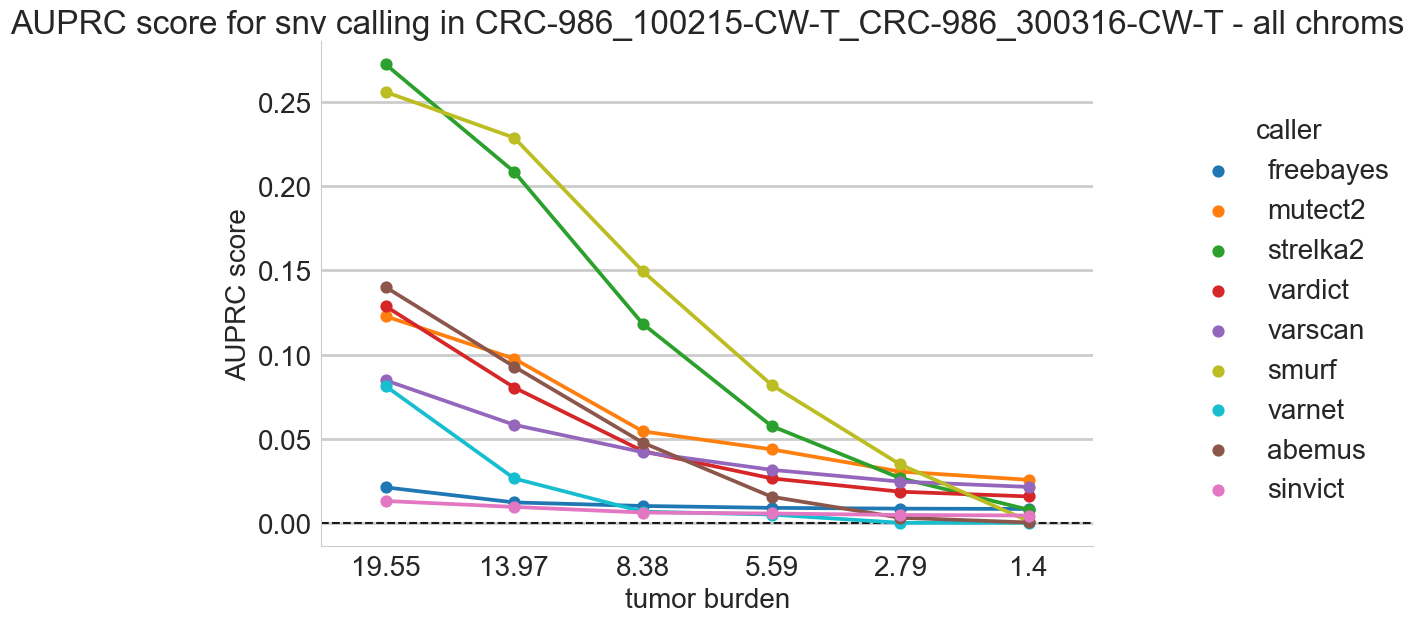

mixture_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
41.90
41.90_freebayes_score
is present
41.90_mutect2_score
is present
41.90_strelka2_score
is present
41.90_vardict_score
is present
41.90_varscan_score
is present
41.90_smurf_score
is present
41.90_varnet_score
is present
41.90_abemus_score
is present
41.90_sinvict_score
is present
mixture_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_80x
19.55
19.55_freebayes_score
is present
0.03
19.55_mutect2_score
is present
0.03
19.55_strelka2_score
is present
0.03
19.55_vardict_score
is present
0.03
19.55_varscan_score
is present
0.03
19.55_smurf_score
is present
0.03
19.55_varnet_score
is present
0.03
19.55_abemus_score
is present
0.03
19.55_sinvict_score
is present
0.03
mixture_CRC-986_100215-CW-T_50x_CRC-986_300316-CW-T_100x
13.97
13.97_freebayes_score
is present
0.03
13.97_mutect2_score
is present
0.03
13.97_strelka2_score
is present
0.03
13.97_vardict_score
is present
0.03
13.97_varscan_score
is present
0.03
13.97_smurf_score
is present
0

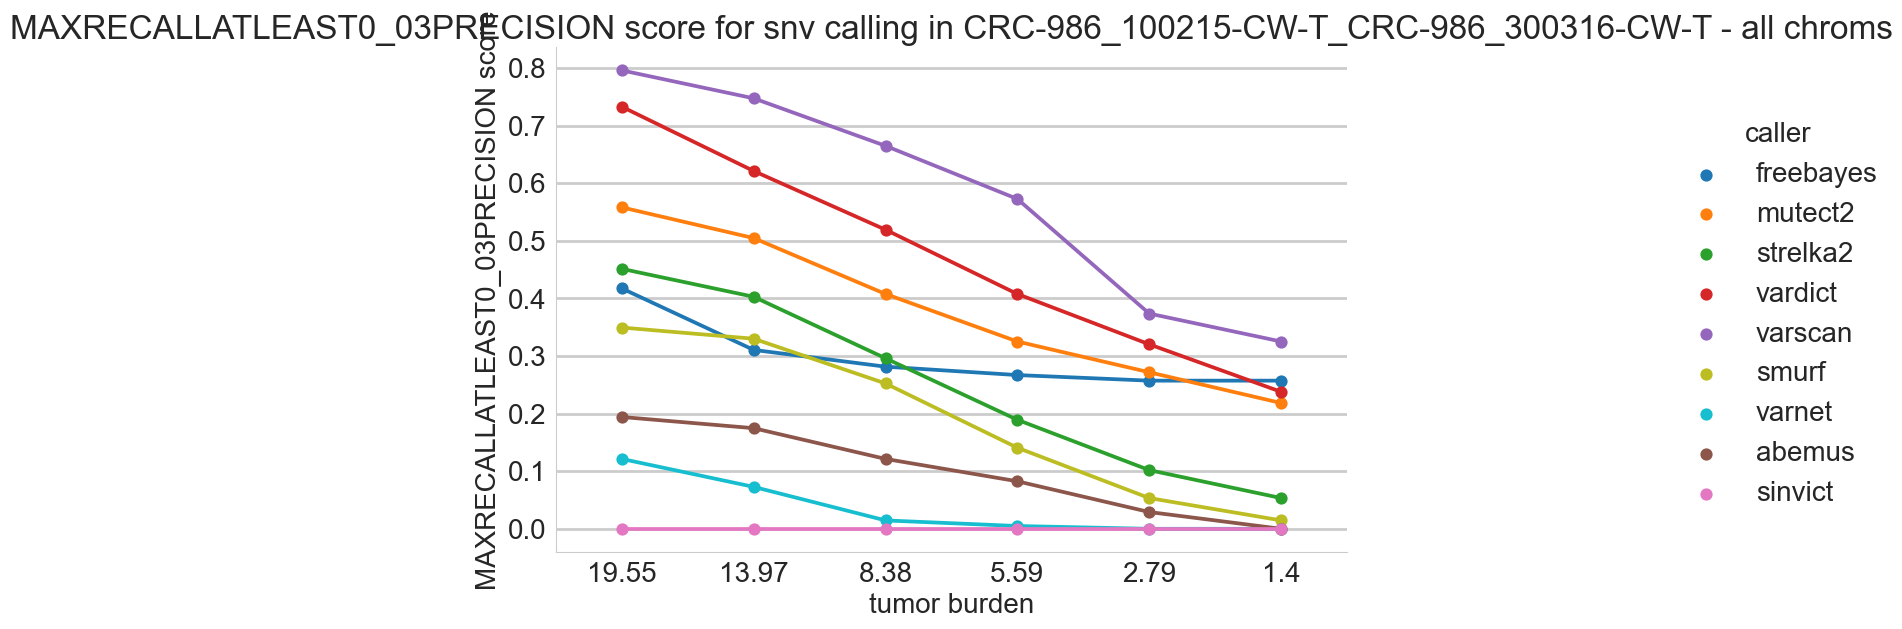

In [6]:
muttype = 'snv'
mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
#mixtureid = 'CRC-123_310715-CW-T_CRC-123_121115-CW-T'
#mixtureid = 'BRA-412_240820-CW-T_BRA-412_060220-CW-T'
calltablesseries = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', mixtureid+'_'+muttype+'_calls_all.csv'), index_col=0)
aux = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', mixtureid+'_tf_cov.csv'),index_col=0)
if muttype == 'snv':
    gtm = 5
else:
    gtm = 4
refsample = 'undiluted'
fixedvar = 'coverage'
#fixedvar = 'ctdna'
if fixedvar == 'coverage':
    if 'BRA' in mixtureid:
        seriesorder = [(100, 0), (70, 30), (50, 50), (30, 70), (20, 80), (10, 90)] 
    else: # mixtureid.contains('CRC')
        seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(100, 0), (100, 50), (100, 100)]
    xaxis = 'coverage'
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
calltablesseries = generate_groundtruth(config, calltablesseries, aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])
results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                 refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis, diltype='mixture')
results_maxrecallatlast0_03precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_03precision', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis, diltype='mixture')

['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
test
40.00_freebayes      2889
40.00_mutect2        2040
40.00_strelka2      23067
40.00_vardict      330240
40.00_varscan        8958
40.00_varnet           46
40.00_abemus        15551
40.00_sinvict        9774
dtype: object
False    571330
True        285
Name: truth, dtype: int64
40.00_freebayes    231
40.00_mutect2      153
40.00_strelka2     231
40.00_vardict      279
40.00_varscan      282
40.00_smurf         57
40.00_varnet        46
40.00_abemus       127
40.00_sinvict      255
dtype: object
mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_0x
40.00
40.00_freebayes_score
is present
40.00_mutect2_score
is present
40.00_strelka2_score
is present
40.00_vardict_score
is present
40.00_varscan_score
is present
40.00_smurf_score
is present
40.00_varnet_score
is present
40.00_abemus_score
is present
40.00

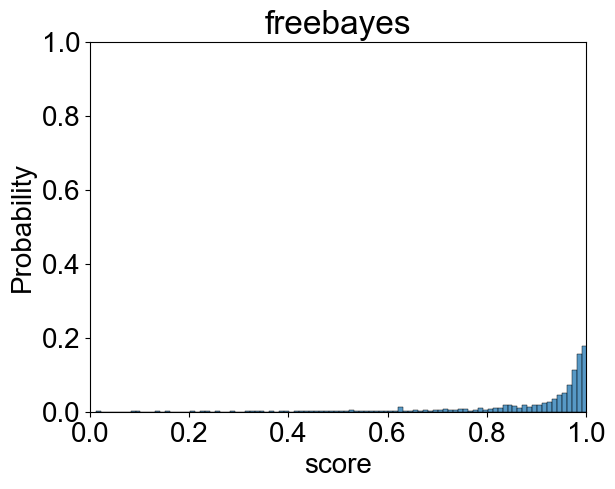

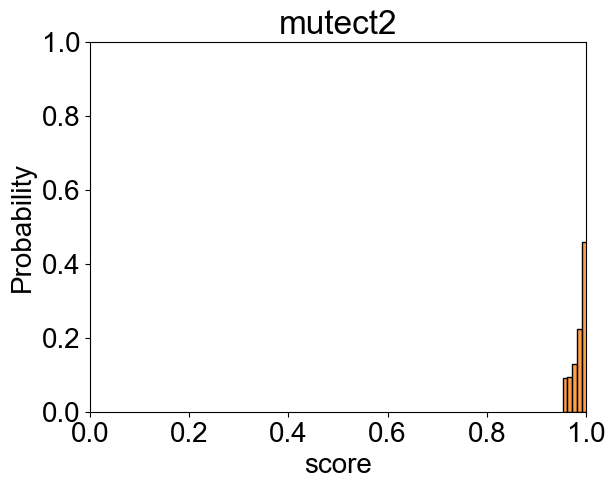

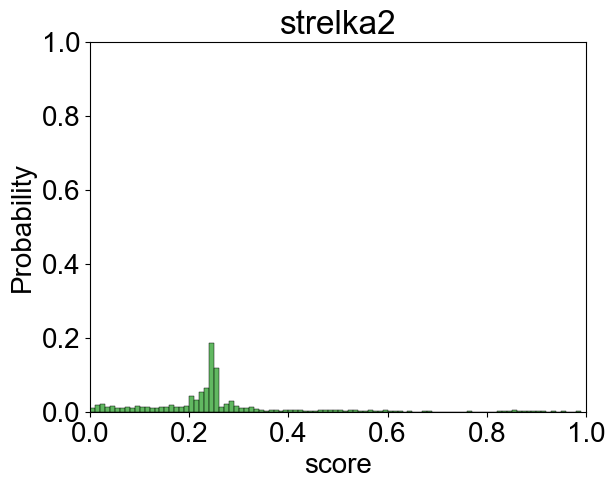

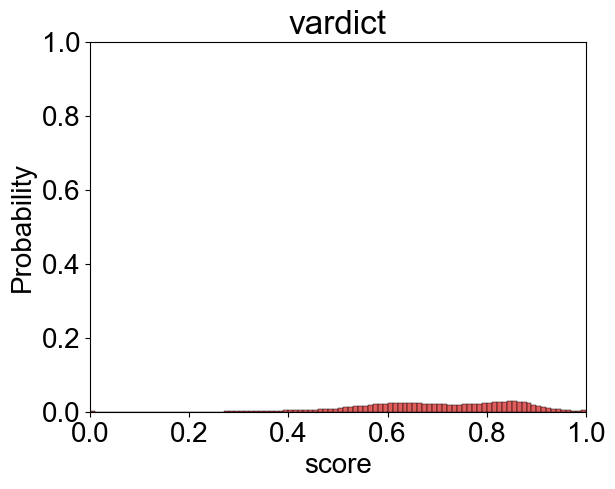

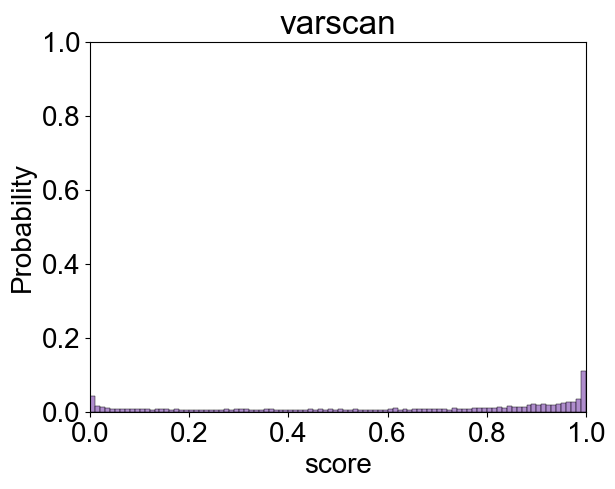

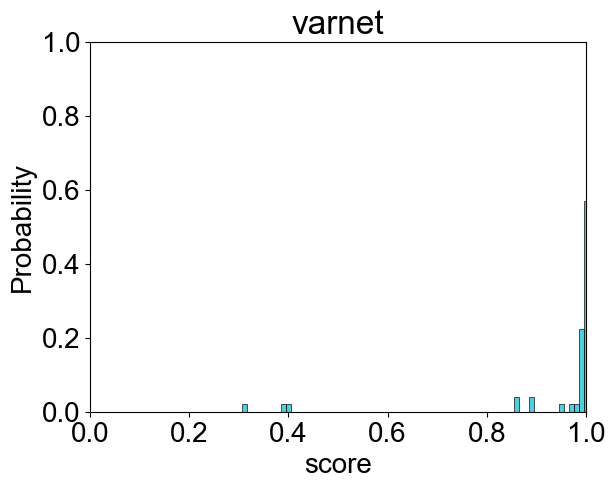

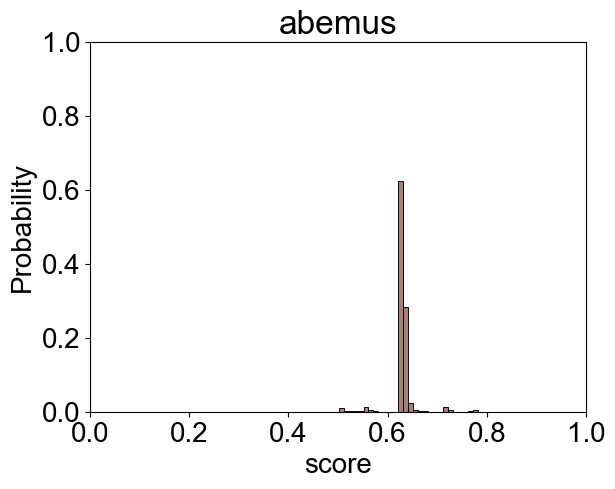

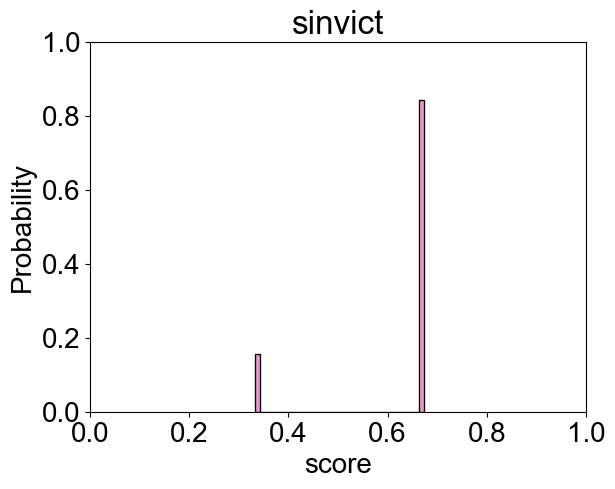

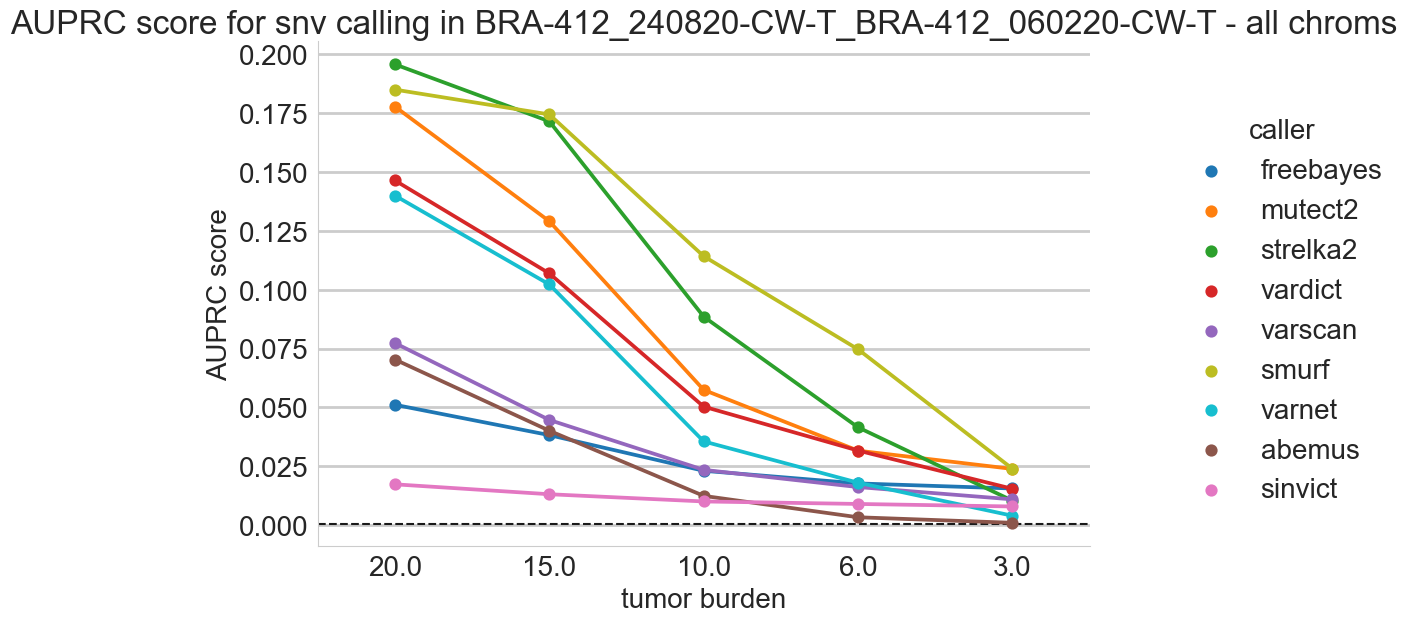

mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_0x
40.00
40.00_freebayes_score
is present
40.00_mutect2_score
is present
40.00_strelka2_score
is present
40.00_vardict_score
is present
40.00_varscan_score
is present
40.00_smurf_score
is present
40.00_varnet_score
is present
40.00_abemus_score
is present
40.00_sinvict_score
is present
mixture_BRA-412_240820-CW-T_70x_BRA-412_060220-CW-T_30x
20.00
20.00_freebayes_score
is present
0.03
20.00_mutect2_score
is present
0.03
20.00_strelka2_score
is present
0.03
20.00_vardict_score
is present
0.03
20.00_varscan_score
is present
0.03
20.00_smurf_score
is present
0.03
20.00_varnet_score
is present
0.03
20.00_abemus_score
is present
0.03
20.00_sinvict_score
is present
0.03
mixture_BRA-412_240820-CW-T_50x_BRA-412_060220-CW-T_50x
15.00
15.00_freebayes_score
is present
0.03
15.00_mutect2_score
is present
0.03
15.00_strelka2_score
is present
0.03
15.00_vardict_score
is present
0.03
15.00_varscan_score
is present
0.03
15.00_smurf_score
is present
0

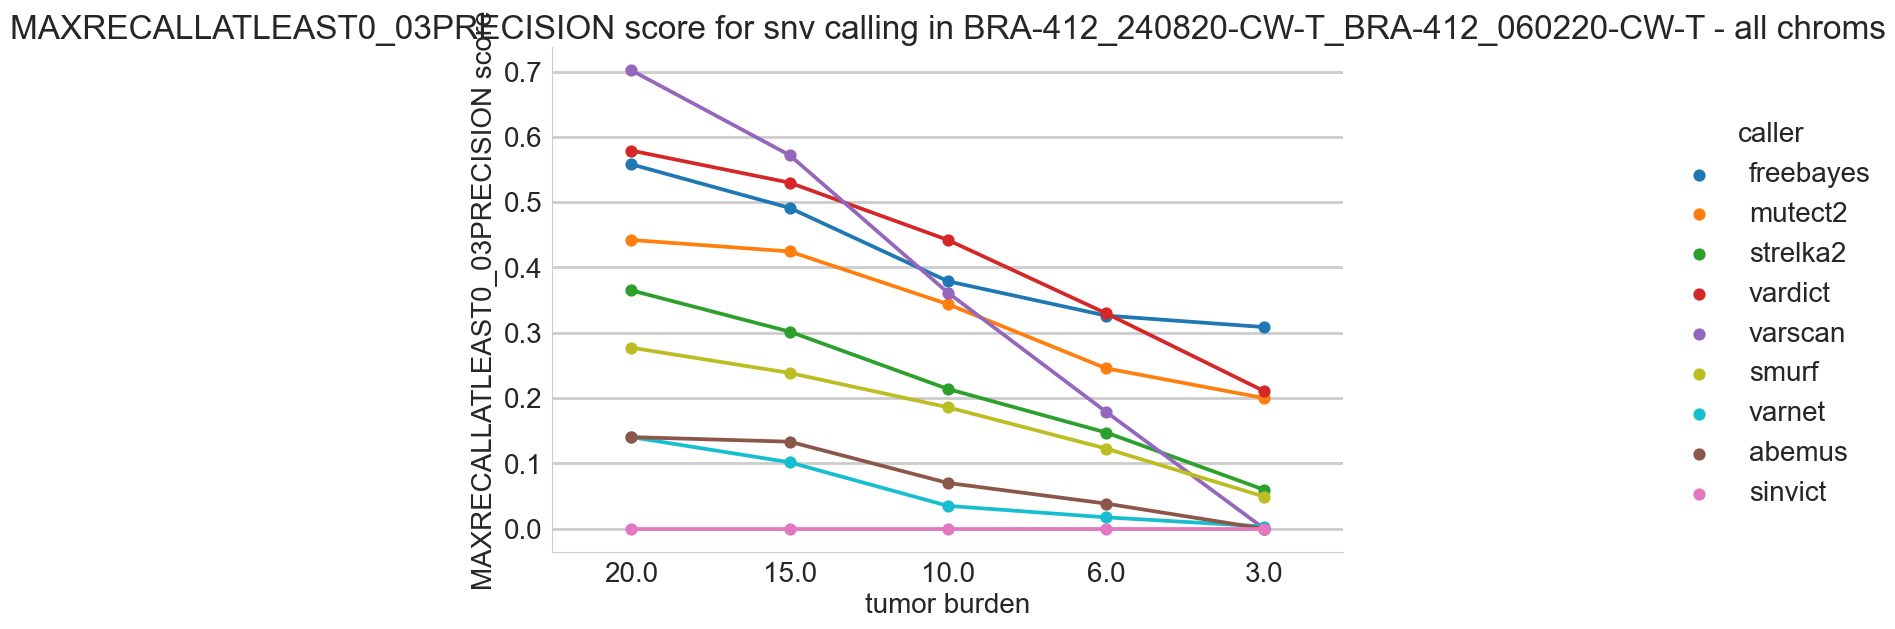

In [147]:
calltablesseries = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T_snv_calls_all.csv'), index_col=0)
aux = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T_tf_cov.csv'),index_col=0)
gtm = 5
muttype = 'snv'
refsample = 'undiluted'
fixedvar = 'coverage'
#fixedvar = 'ctdna'
if fixedvar == 'coverage':
    seriesorder = [(100, 0), (70, 30), (50, 50), (30, 70), (20, 80), (10, 90)] 
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(100, 0), (100, 50), (100, 100)]
    xaxis = 'coverage'
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
calltablesseries = generate_groundtruth(config, calltablesseries, aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])
results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                 refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis, diltype='mixture')
results_maxrecallatlast0_03precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_03precision', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis, diltype='mixture')

['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict']
test
40.00_freebayes      356
40.00_mutect2        381
40.00_strelka2       193
40.00_vardict      16942
40.00_varscan        647
40.00_varnet           7
40.00_abemus           0
40.00_sinvict        976
dtype: object
False    31281
True        79
Name: truth, dtype: int64
40.00_freebayes    61
40.00_mutect2      51
40.00_strelka2     51
40.00_vardict      69
40.00_varscan      73
40.00_smurf         6
40.00_varnet        7
40.00_abemus        0
40.00_sinvict      27
dtype: object
mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_0x
40.00
40.00_freebayes_score
is present
40.00_mutect2_score
is present
40.00_strelka2_score
is present
40.00_vardict_score
is present
40.00_varscan_score
is present
40.00_smurf_score
is present
40.00_varnet_score
is present
40.00_abemus_score
is present
40.00_sinvict_score
is p

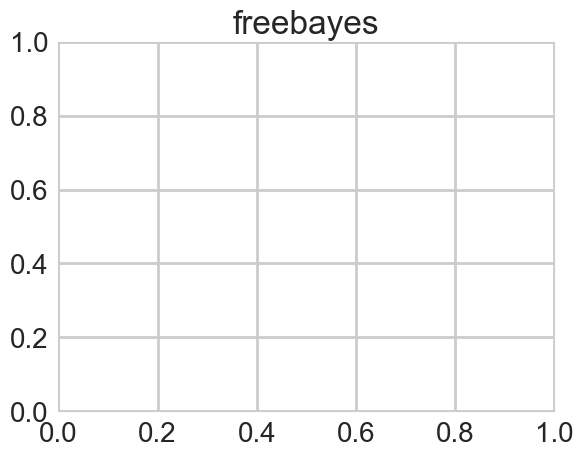

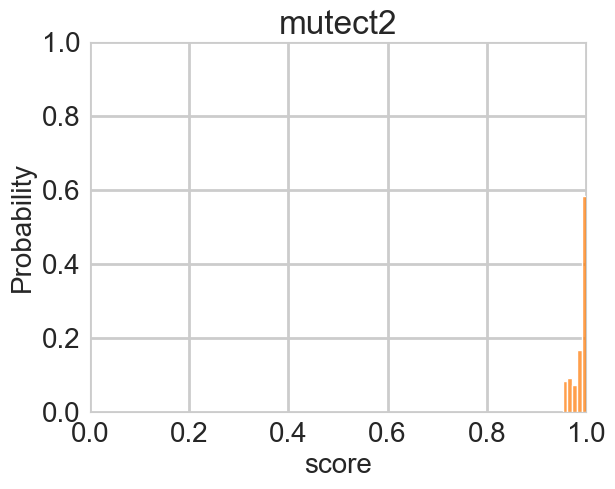

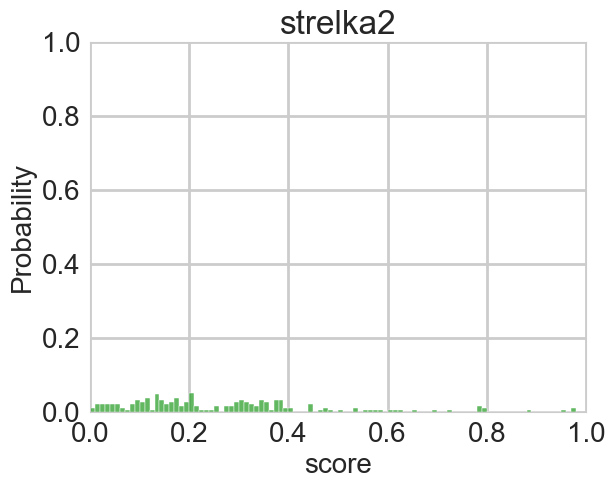

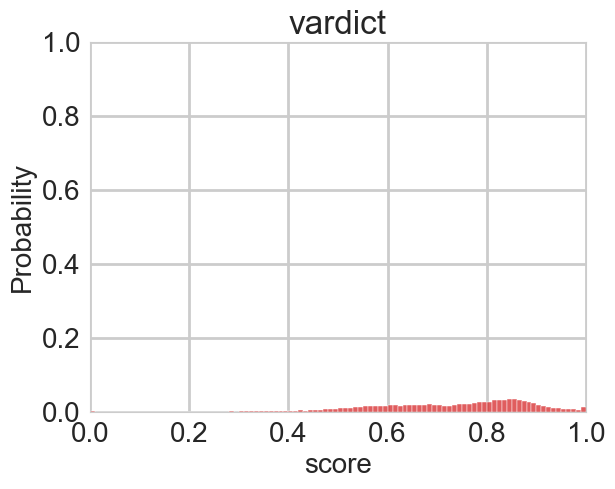

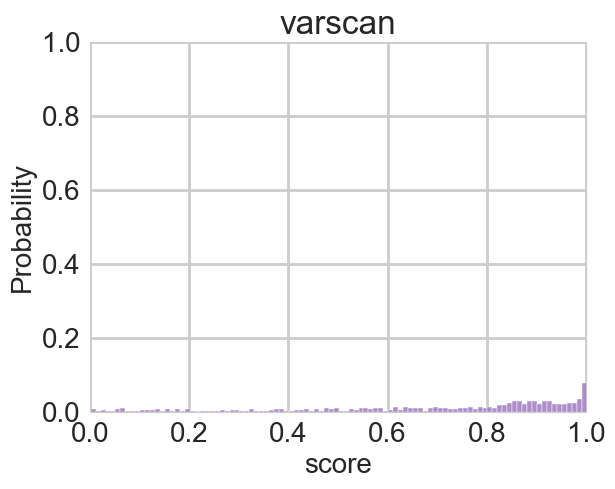

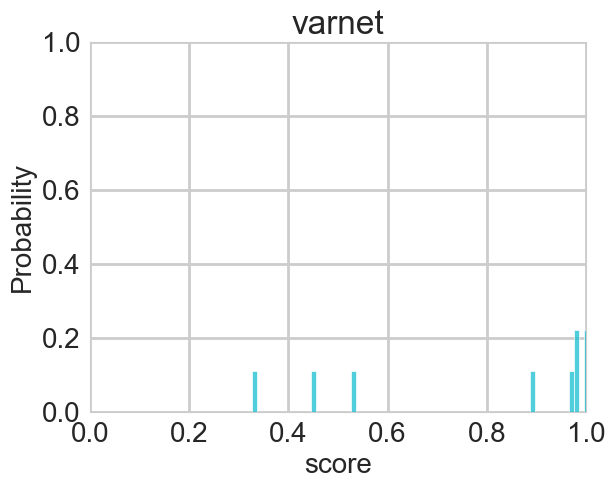

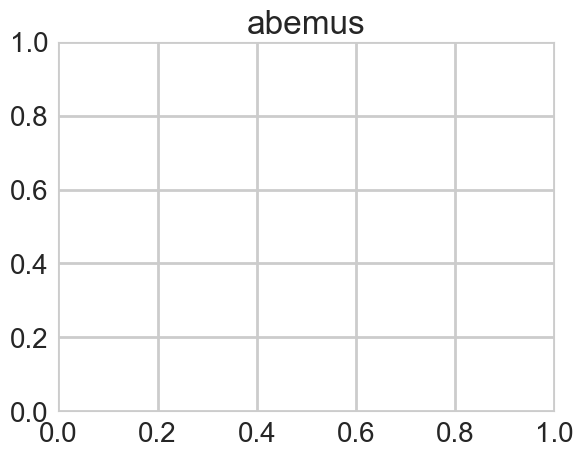

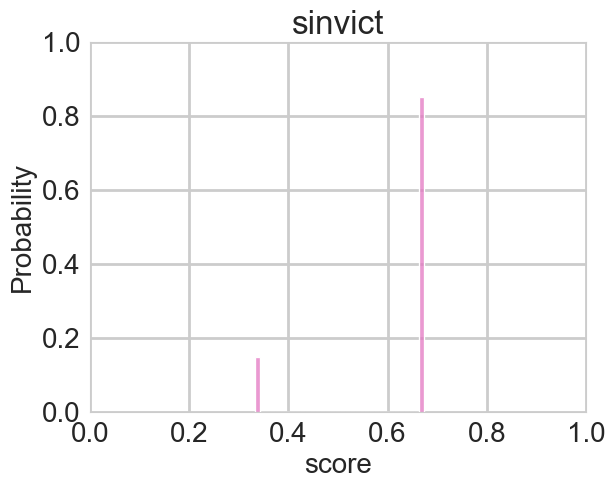

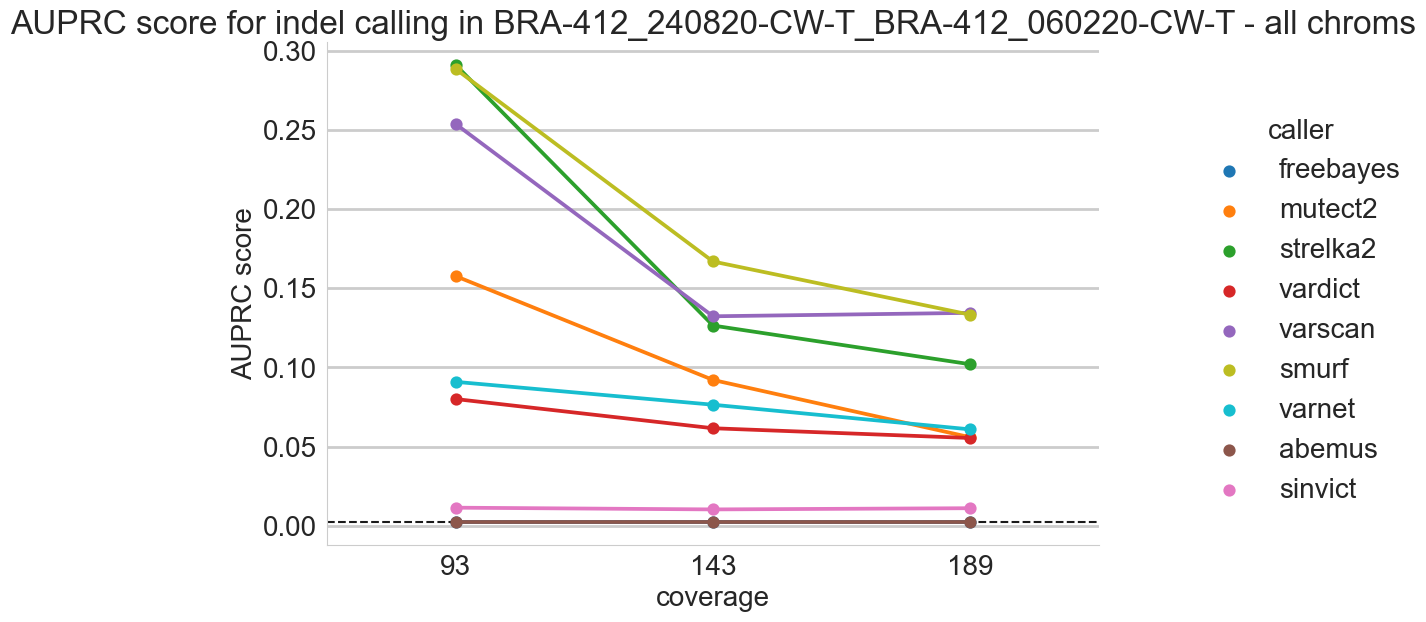

mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_0x
40.00
40.00_freebayes_score
is present
0.03
40.00_mutect2_score
is present
0.03
40.00_strelka2_score
is present
0.03
40.00_vardict_score
is present
0.03
40.00_varscan_score
is present
0.03
40.00_smurf_score
is present
0.03
40.00_varnet_score
is present
0.03
40.00_abemus_score
is present
0.03
40.00_sinvict_score
is present
0.03
mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_50x
18.00
18.00_freebayes_score
is present
0.03
18.00_mutect2_score
is present
0.03
18.00_strelka2_score
is present
0.03
18.00_vardict_score
is present
0.03
18.00_varscan_score
is present
0.03
18.00_smurf_score
is present
0.03
18.00_varnet_score
is present
0.03
18.00_abemus_score
is present
0.03
18.00_sinvict_score
is present
0.03
mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_100x
8.00
8.00_freebayes_score
is present
0.03
8.00_mutect2_score
is present
0.03
8.00_strelka2_score
is present
0.03
8.00_vardict_score
is present
0.03
8.00_varscan_score
is p

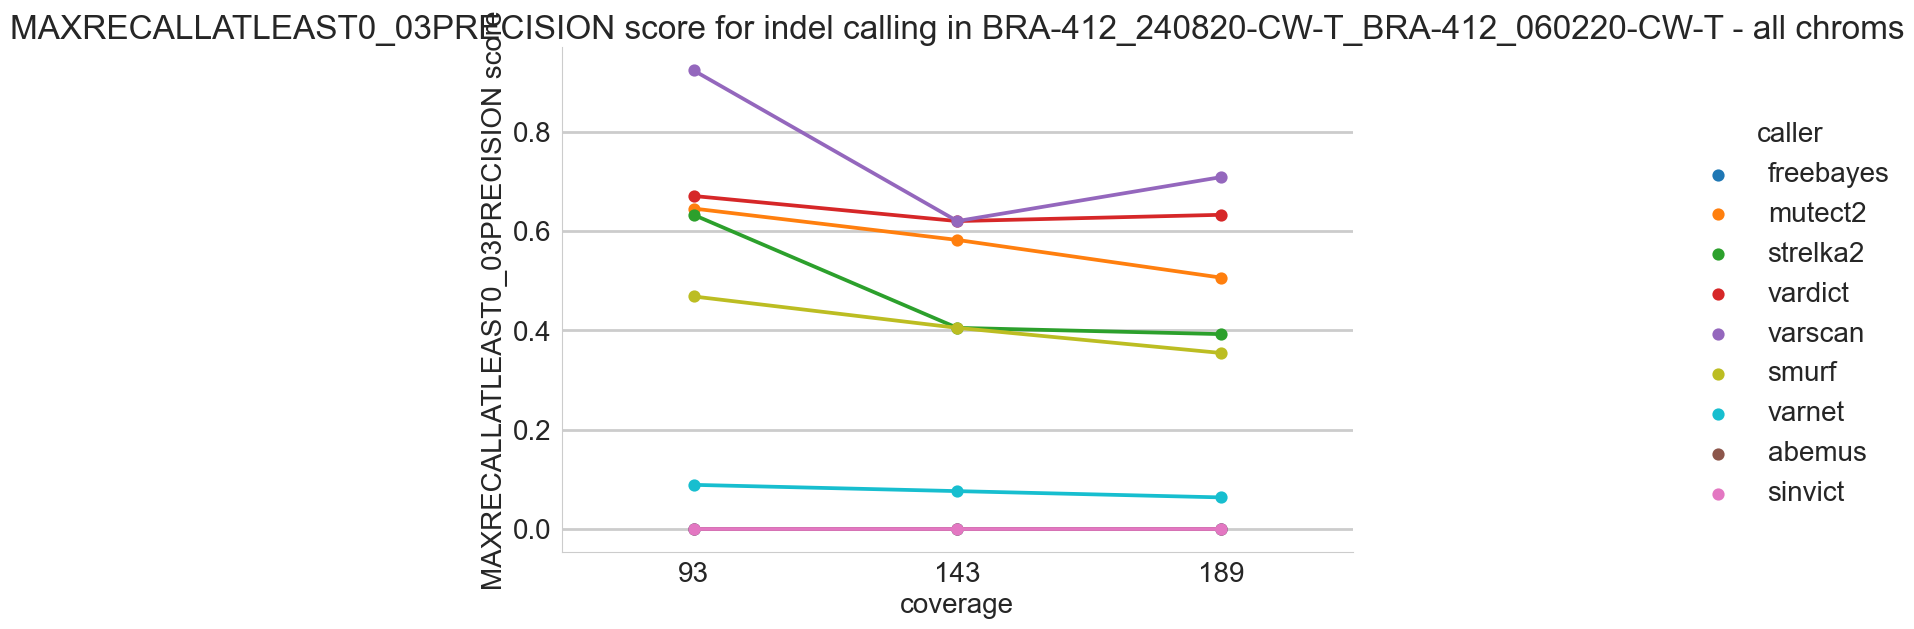

In [16]:
calltablesseries = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T_indel_calls_all.csv'), index_col=0)
aux = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'BRA-412_240820-CW-T_BRA-412_060220-CW-T_tf_cov.csv'),index_col=0)
gtm = 4
muttype = 'indel'
refsample = 'undiluted'
#fixedvar = 'coverage'
fixedvar = 'ctdna'
if fixedvar == 'coverage':
    seriesorder = [(100, 0), (70, 30), (50, 50), (30, 70), (20, 80), (10, 90)] 
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(100, 0), (100, 50), (100, 100)]
    xaxis = 'coverage'
save=True
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
calltablesseries = generate_groundtruth(config, calltablesseries, aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])
results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                 refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis, diltype='mixture')
results_maxrecallatlast0_03precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_03precision', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis, diltype='mixture')

In [ ]:
results_maxrecallatlast0_05precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxrecallatleast0_03precision', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)

In [9]:
print(calltablesseries['truth'].value_counts())

False    962139
True        206
Name: truth, dtype: int64


In [45]:
3*10e6 == 30000000

True

In [51]:
print(calltablesseries.shape[0])
print(calltablesseries['truth'].value_counts())
print(calltablesseries[calltablesseries['truth'] == True].shape[0] / calltablesseries.shape[0])
print(calltablesseries[calltablesseries['truth'] == True].shape[0] / (3*10e6))
print(72815 * calltablesseries[calltablesseries['truth'] == True].shape[0] / (3*10e6))
print(0.03 / (calltablesseries[calltablesseries['truth'] == True].shape[0] /(3*10e6)) )
print(0.03 / (calltablesseries[calltablesseries['truth'] == True].shape[0] / calltablesseries.shape[0] ))

print(100000 * (calltablesseries[calltablesseries['truth'] == True].shape[0] /(3*10e6)) )
print(500 * (calltablesseries[calltablesseries['truth'] == True].shape[0] / calltablesseries.shape[0] ))

962345
False    962139
True        206
Name: truth, dtype: int64
0.00021406044609781314
6.8666666666666664e-06
0.4999963333333333
4368.9320388349515
140.14733009708738
0.6866666666666666
0.10703022304890657


In [48]:
list(config.methods)

['freebayes',
 'mutect2',
 'strelka2',
 'vardict',
 'varscan',
 'smurf',
 'varnet',
 'abemus',
 'sinvict']

# GT analysis

In [ ]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)
print(config.methods)

In [ ]:
mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
#mixtureid = 'CRC-123_310715-CW-T_CRC-123_121115-CW-T'

fixedvar = 'coverage'
if fixedvar == 'coverage':
    seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(70, 0), (70, 80), (70, 180)]
    xaxis = 'coverage'
#for mixtureid in mixtureids:
#mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
print('############# {} ############'.format(mixtureid))
if mixtureid ==  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T':
    chroms = [str(c) for c in range(1,23) if c != 2 and c!=6 and c !=17 and c!=19 and c!=20 and c!=21]
    #chroms = [str(c) for c in range(1,9) if c != 2 and c!=6]
elif mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=8 and c!=20 and c!=21 and c!=22] 
else:
    chroms = [str(c) for c in range(1,23) if c !=6 and c!=19 and c!=20]  # c !=1 and c!= 2 and
calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
aux_all = []
calltable_snv, aux = get_calltableseries(config, mixtureid, chroms, muttype='snv', filterparam=filterparam, reload=reload, save=save)
calltable_indel, aux = get_calltableseries(config, mixtureid, chroms, muttype='indel', filterparam=filterparam, reload=reload, save=save)
calltable_snp, aux = get_calltableseries(config, mixtureid, chroms, muttype='snp', filterparam=filterparam, reload=reload, save=save)
print(calltable_snv.shape, calltable_indel.shape, calltable_snp.shape)
print(aux)
plasmasample = '_'.join(mixtureid.split('_')[:2])
print(plasmasample)
healthysample = '_'.join(mixtureid.split('_')[2:])
print(healthysample)
calltables['snv'].append(calltable_snv)
calltables['indel'].append(calltable_indel)
calltables['snp'].append(calltable_snp)
calltables['sampleid'] = mixtureid 
calltables['tf'] = np.unique([cn.split('_')[0] for cn in list(calltable_snv.columns)])[:-5].astype(float)
calltables['snv'] = pd.concat(calltables['snv'])
calltables['indel'] = pd.concat(calltables['indel'])
calltables['snp'] = pd.concat(calltables['snp'])
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
#for muttype in muttypes:
muttype = 'snv'
refsample = 'undiluted'
if muttype == 'snv':
    gtm = 5
else:  # elif muttype == 'indel':
    gtm = 3
print(max(aux['tf']))
#if mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T' and muttype == 'snv':
#    gtm = 3
#    refsample = 'tissue'
#    #calltablesseries  = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method='tissue', muttype=muttype,
#    #                                    matchedtissuepath=os.path.join('data', 'matchedtissue', 'NCC_CRC-986_100215-T1W', 'calls', 'NCC_CRC-986_100215-T1W_snv_calls_PASS_exome.csv'))
#    calltablesseries  = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method='tissue', muttype=muttype,
#                                        matchedtissuepath=os.path.join('data', 'matchedtissue_ultradeep', '986_100215_T1-E', 'calls', '986_100215_T1-E_snv_calls_all.csv'))
if mixtureid !=  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'abemus', 'sinvict'])
else:
    calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype,
                                        matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])

In [ ]:
gtdf = calltablesseries[calltablesseries['truth'] == True]
gtdf['median_vaf'] = gtdf[['{:.2f}_{}_vaf'.format(aux['tf'].max(), m) for m in config.methods if '{:.2f}_{}_vaf'.format(aux['tf'].max(), m) in gtdf.columns]].median(axis=1, skipna=True)
sns.histplot(data=gtdf, x="median_vaf", bins=30, stat='frequency')

In [ ]:
gtdf['median_vaf'].to_csv('figures/figure2b/gt_986_exome_150x_atleast5callersinundilutedsample_snv.csv')

In [ ]:
calltablesseries.loc[ac.loc[ac.index.duplicated()].index]

In [ ]:
Bwithoutab.loc[Bwithoutab.loc[Bwithoutab.index.duplicated()].index]

In [ ]:
A = pd.read_csv('figures/figure2b/gt_986_exome_150x_atleast5callersinundilutedsample_snv.csv', index_col=0)
B = pd.read_csv('figures/figure2b/gt_986_exome_2000x_atleast5callersinundilutedsample_snv.csv', index_col=0)
print(A.shape[0], B.shape[0])
ab = list(set(set(list(A.index)) & set(list(B.index))))
len(ab)
Awithoutab = A.loc[list(set(A.index) - set(ab))]
Bwithoutab = B.loc[list(set(B.index) - set(ab))]

plt.figure(figsize=(10,10))

#calltablesseries = pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T_snv_calls_all.csv'), index_col=0, memory_map=True)
aux = pd.read_csv(os.path.join('data', 'mixtures_ultradeep', 'mixtures_chrall', 'mixtures_chrall_CRC-986_100215-CW-T_CRC-986_300316-CW-T' , 'calls', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T_tf_cov.csv'), index_col=0)
ac = pd.DataFrame(calltablesseries.loc[[a for a in list(Bwithoutab.index) if a in calltablesseries.index]][['{:.2f}_{}_vaf'.format(aux['tf'].max(), m) for m in config.methods if ('{:.2f}_{}'.format(aux['tf'].max(), m) in calltablesseries.columns) and (m != 'smurf')]].median(skipna=True, axis=1))
ac = ac[~ac.index.duplicated()]
Bwithoutab = Bwithoutab[~Bwithoutab.index.duplicated()]
comp = pd.concat([ac, Bwithoutab], axis=1)
comp.columns = ['vaf 150x', 'vaf 2000x']
comp.fillna(0, inplace=True)
list_only2000x = list(comp.index)
print(Bwithoutab.shape[0], ac.shape[0])
sns.histplot(x='vaf 150x', y='vaf 2000x', data=comp, binwidth=0.01, binrange=[0,.5], alpha=1, color='tab:blue', label='2000x only')

comp = pd.concat([A.loc[ab], B.loc[ab]], axis=1)
comp.columns = ['vaf 150x', 'vaf 2000x']
comp.fillna(0, inplace=True)
list_both = list(comp.index)
sns.histplot(x='vaf 150x', y='vaf 2000x', data=comp, binwidth=0.01, binrange=[0,.5], alpha=1, color='tab:red', label='both')

#table_ultradeep = pd.read_csv(os.path.join('data', 'mixtures_ultradeep', 'mixtures_chrall', 'mixtures_chrall_CRC-986_100215-CW-T_CRC-986_300316-CW-T' , 'calls', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T_snv_calls_all.csv'), index_col=0, memory_map=True)
#aux_ultradeep = pd.read_csv(os.path.join('data', 'mixtures_ultradeep', 'mixtures_chrall', 'mixtures_chrall_CRC-986_100215-CW-T_CRC-986_300316-CW-T' , 'calls', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T_tf_cov.csv'), index_col=0)
#table_ultradeep = generate_groundtruth(config, table_ultradeep, aux_ultradeep['tf'], ground_truth_method=5, muttype='snv', matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])

ac = calltablesseries.loc[[a for a in list(Awithoutab.index) if a in table_ultradeep.index]][['{:.2f}_{}_vaf'.format(aux_ultradeep['tf'].max(), m) for m in config.methods if ('{:.2f}_{}'.format(aux_ultradeep['tf'].max(), m) in table_ultradeep.columns) and (m != 'smurf')]].median(skipna=True, axis=1)
comp = pd.concat([Awithoutab, ac], axis=1)
comp.columns = ['vaf 150x', 'vaf 2000x']
comp.fillna(0, inplace=True)
list_only150x = list(comp.index)
print(Awithoutab.shape[0], ac.shape[0])
sns.histplot(x='vaf 150x', y='vaf 2000x', data=comp, binwidth=0.01, binrange=[0,.5], alpha=1, color='tab:olive', label='150x only')

from matplotlib.lines import Line2D
a = Line2D([0], [0], color='tab:red', lw=4)
b = Line2D([0], [0], color='tab:blue', lw=4)
c = Line2D([0], [0], color='tab:olive', lw=4)

plt.legend([b, a,  c], [ 'both', '2000x only', '150x only'], bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [ ]:
A = pd.read_csv('figures/figure2b/gt_986_exome_150x_atleast5callersinundilutedsample_snv.csv', index_col=0)
B = pd.read_csv('figures/figure2b/gt_986_exome_2000x_atleast5callersinundilutedsample_snv.csv', index_col=0)
print(A.shape[0], B.shape[0])
ab = list(set(set(list(A.index)) & set(list(B.index))))
len(ab)
Awithoutab = A.loc[list(set(A.index) - set(ab))]
Bwithoutab = B.loc[list(set(B.index) - set(ab))]

plt.figure(figsize=(10,10))
ac = pd.DataFrame(calltablesseries.loc[[a for a in list(Bwithoutab.index) if a in calltablesseries.index]][['{:.2f}_{}_vaf'.format(aux['tf'].max(), m) for m in config.methods if ('{:.2f}_{}'.format(aux['tf'].max(), m) in calltablesseries.columns) and (m != 'smurf')]].median(skipna=True, axis=1))
ac = ac[~ac.index.duplicated()]
Bwithoutab = Bwithoutab[~Bwithoutab.index.duplicated()]
comp = pd.concat([ac, Bwithoutab], axis=1)
comp.fillna(0, inplace=True)
comp.columns = ['vaf 150x', 'vaf 2000x']
print(Bwithoutab.shape[0], ac.shape[0])
sns.histplot(x='vaf 150x', y='vaf 2000x', data=comp, binwidth=0.01, binrange=[0,1], alpha=1, color='g', label='2000x only')

comp = pd.concat([A.loc[ab], B.loc[ab]], axis=1)
comp.columns = ['vaf 150x', 'vaf 2000x']
sns.histplot(x='vaf 150x', y='vaf 2000x', data=comp, binwidth=0.01, binrange=[0,1], alpha=1, label='both')

table_ultradeep = pd.read_csv(os.path.join('data', 'mixtures_ultradeep', 'mixtures_chrall', 'mixtures_chrall_CRC-986_100215-CW-T_CRC-986_300316-CW-T' , 'calls', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T_snv_calls_all.csv'), index_col=0, memory_map=True)
aux_ultradeep = pd.read_csv(os.path.join('data', 'mixtures_ultradeep', 'mixtures_chrall', 'mixtures_chrall_CRC-986_100215-CW-T_CRC-986_300316-CW-T' , 'calls', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T_tf_cov.csv'), index_col=0)
table_ultradeep = generate_groundtruth(config, table_ultradeep, aux_ultradeep['tf'], ground_truth_method=5, muttype='snv', matchedtissuepath=None, methods=['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan', 'varnet', 'abemus', 'sinvict'])

ac = calltablesseries.loc[[a for a in list(Awithoutab.index) if a in table_ultradeep.index]][['{:.2f}_{}_vaf'.format(aux_ultradeep['tf'].max(), m) for m in config.methods if ('{:.2f}_{}'.format(aux_ultradeep['tf'].max(), m) in table_ultradeep.columns) and (m != 'smurf')]].median(skipna=True, axis=1)
comp = pd.concat([Awithoutab, ac], axis=1)
comp.fillna(0, inplace=True)
comp.columns = ['vaf 150x', 'vaf 2000x']
print(Awithoutab.shape[0], ac.shape[0])
sns.histplot(x='vaf 150x', y='vaf 2000x', data=comp, binwidth=0.01, binrange=[0,1], alpha=1, color='r', label='150x only')

from matplotlib.lines import Line2D
a = Line2D([0], [0], color='g', lw=4)
b = Line2D([0], [0], color='b', lw=4)
c = Line2D([0], [0], color='r', lw=4)

plt.legend([b, a,  c], [ 'both', '2000x only', '150x only'], bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [ ]:
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests

# contingency table and Fisher exact test

print(len(list(A.index)), len(list(B.index)))
A = A[~A.index.duplicated()]
B = B[~B.index.duplicated()]
print(len(list(A.index)), len(list(B.index)))
res = pd.concat([A, B], axis=1)
res[res.isna()] = False
res[res != False] = True
res.columns = ['150x', '2000x']

testres = {}
a, b = '150x', '2000x'
print("############")
print(a, 'VS', b)
print("############")
ctable = [[res[(res[a]==True) & (res[b]==True)].shape[0], res[(res[a]==False) & (res[b]==True)].shape[0]],
          [res[(res[a]==True) & (res[b]==False)].shape[0], int(20000 - res[(res[a]==True) | (res[b]==True)].shape[0])]]

#p_adjusted = multipletests(Column6, method='bonferroni')
odd_ratio, p_value = fisher_exact(ctable, alternative='two-sided')
print('Contingency table:')
print(pd.DataFrame(ctable, columns=[a, '!'+a], index=[b, '!'+b]))
print('Fisher exact test (two-sided): odd_ratio = {}, p_value = {}'.format(odd_ratio, p_value))
testres[a+' VS '+b] = [p_value]

In [ ]:
 int(res[(res[a]==True) | (res[b]==True)].shape[0])

In [ ]:
list(calltablesseries[calltablesseries['truth'] == True][['{:.2f}_{}_score'.format(aux['tf'].max(), m) for m in config.methods]].index)

In [ ]:
import matplotlib.transforms as transforms

patient = mixtureid.split('-')[1].split('_')[0]
print(patient)
gtanalysis = calltablesseries[calltablesseries['truth'] == True][['{:.2f}_{}'.format(aux['tf'].max(), m) for m in config.methods]]
initialanalysis = calltablesseries[calltablesseries['truth'] == False][['{:.2f}_{}'.format(aux['tf'].max(), m) for m in config.methods]]
ngt = gtanalysis.shape[0]
print(ngt)
gtanalysis = pd.DataFrame(gtanalysis.sum()).T
gtanalysis.columns = [l.split('_')[1] for l in list(gtanalysis.columns)]
gtanalysis.index = ['calls in GT']
initialanalysis = pd.DataFrame(initialanalysis.sum()).T
initialanalysis.columns = [l.split('_')[1] for l in list(initialanalysis.columns)]
initialanalysis.index = ['calls not in GT']

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(gtanalysis.columns, gtanalysis.values.flatten(), bottom=1, color=[config.colors[config.methods.index(m)] for m in gtanalysis.columns], width=1)
plt.axhline(y=ngt, c='blue', lw='3')
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, ngt, "{:.0f}".format(ngt), color="blue", transform=trans, ha="right", va="center")
for col in initialanalysis.columns:
    print(col, initialanalysis[col].values[0], gtanalysis[col].values[0])
    plt.bar(col, initialanalysis[col].values[0], bottom=gtanalysis[col].values[0], label=col, color='grey', alpha=0.5, width=1)
        
for pi, p in enumerate(ax.patches):
    print(pi, p)
    if pi < (len(ax.patches)/2):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                20, 
                '{:.0f}'.format(height), 
                horizontalalignment='center')
    else:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/10, 
                '{:.0f}'.format(height), 
                horizontalalignment='center')
ax.set_yscale('log')
plt.ylabel('# SNV')
ax.grid(axis='y')
plt.ylim([1, 5e5])
ax = plt.gca()
ax.set_xticklabels(labels=gtanalysis.columns,rotation=90)
plt.savefig(os.path.join(*config.outputpath, 'figure2a', 'gtanalysis_barplot_'+patient+'_SNV.svg'), bbox_inches='tight')

In [ ]:
import matplotlib.transforms as transforms

gtanalysis = calltablesseries[calltablesseries['truth'] == True][['{:.2f}_{}'.format(aux['tf'].max(), m) for m in config.methods]]
initialanalysis = calltablesseries[calltablesseries['truth'] == False][['{:.2f}_{}'.format(aux['tf'].max(), m) for m in config.methods]]
ngt = gtanalysis.shape[0]
print(ngt)
gtanalysis = pd.DataFrame(gtanalysis.sum()).T
gtanalysis.columns = [l.split('_')[1] for l in list(gtanalysis.columns)]
gtanalysis.index = ['calls in GT']
initialanalysis = pd.DataFrame(initialanalysis.sum()).T
initialanalysis.columns = [l.split('_')[1] for l in list(initialanalysis.columns)]
initialanalysis.index = ['calls not in GT']
gtanalysis = pd.concat([gtanalysis, initialanalysis])
#ax = gtanalysis.T.plot(kind='bar', stacked=True, figsize=(12, 5), rot=0, color=[config.colors[config.methods.index(m)] for m in gtanalysis.columns])
ax = sns.barplot(x=gtanalysis.columns, y='calls in GT', data=gtanalysis.T) #, figsize=(12, 5), rot=0) #, color=[config.colors[config.methods.index(m)] for m in gtanalysis.columns])
ax.set_yscale('log')
for ci, c in enumerate(ax.containers):
    if ci == 0:
        ax.bar_label(c, label_type='center')
    else:
        ax.bar_label(c, label_type='edge')
ax.grid(axis='y')
plt.ylim([1, 5e5])
ax = plt.gca()
ax.set_xticklabels(labels=gtanalysis.columns,rotation=90)
hand, labl = ax.get_legend_handles_labels()
ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
"""
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(gtanalysis.columns, gtanalysis.values.flatten(), color=[config.colors[config.methods.index(m)] for m in gtanalysis.columns], width=.9)
plt.axhline(y=ngt, c='blue', lw='3')
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, ngt, "{:.0f}".format(ngt), color="blue", transform=trans, ha="right", va="center")
for col in initialanalysis.columns:
    print(col, initialanalysis[col].values[0], gtanalysis[col].values[0], bottom=0)
    plt.bar(col, initialanalysis[col].values[0], bottom=gtanalysis[col].values[0], label=col, color='grey', alpha=0.5, width=.9)
ax.set_yscale('log')
plt.ylabel('# SNV')
ax.grid(axis='y')
plt.ylim([1, 5e5])
#plt.savefig(os.path.join(*config.outputpath, 'figure2a', 'gtanalysis_barplot_986_SNV.svg'), bbox_inches='tight')
"""

In [ ]:

results_auprc_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='auprc', ground_truth_method=gtm,
                                 refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_recall_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='recall', ground_truth_method=gtm,
                                       refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_precision_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='precision', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
results_maxf1_df = metric_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, metric='maxf1', ground_truth_method=gtm,
                                      refsample=refsample, muttype=muttype, methods=config.methods, fixedvar=fixedvar, xaxis=xaxis)
figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
                    refsample=refsample, muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=save)

# Part II: (4) Load back metric results and plot combined metric plots

inundilutedsamplebyatleast5callers
CRC-986_100215-CW-T_CRC-986_300316-CW-T CRC-986_100215-CW-T
tb
tumor burden
CRC-986_100215-CW-T
CRC-1014_180816-CW-T
CRC-123_310715-CW-T
BRA-412_240820-CW-T
inundilutedsamplebyatleast5callers
CRC-986_100215-CW-T_CRC-986_300316-CW-T CRC-986_100215-CW-T
coverage
coverage
CRC-986_100215-CW-T
CRC-1014_180816-CW-T
CRC-123_310715-CW-T
BRA-412_240820-CW-T


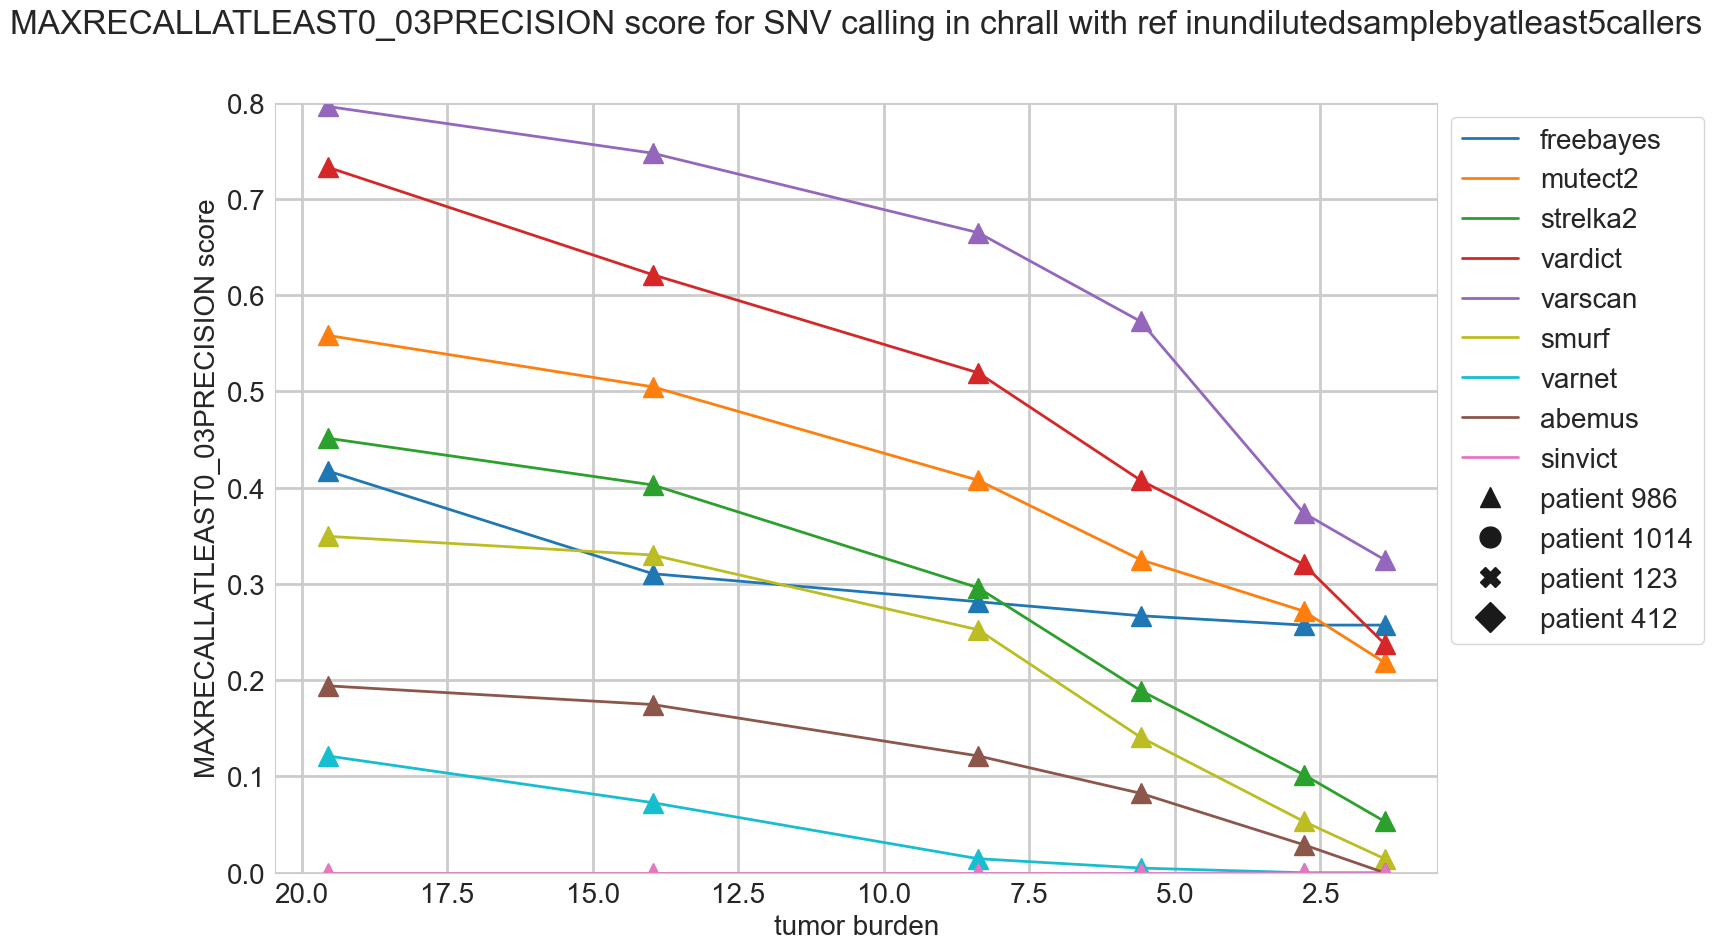

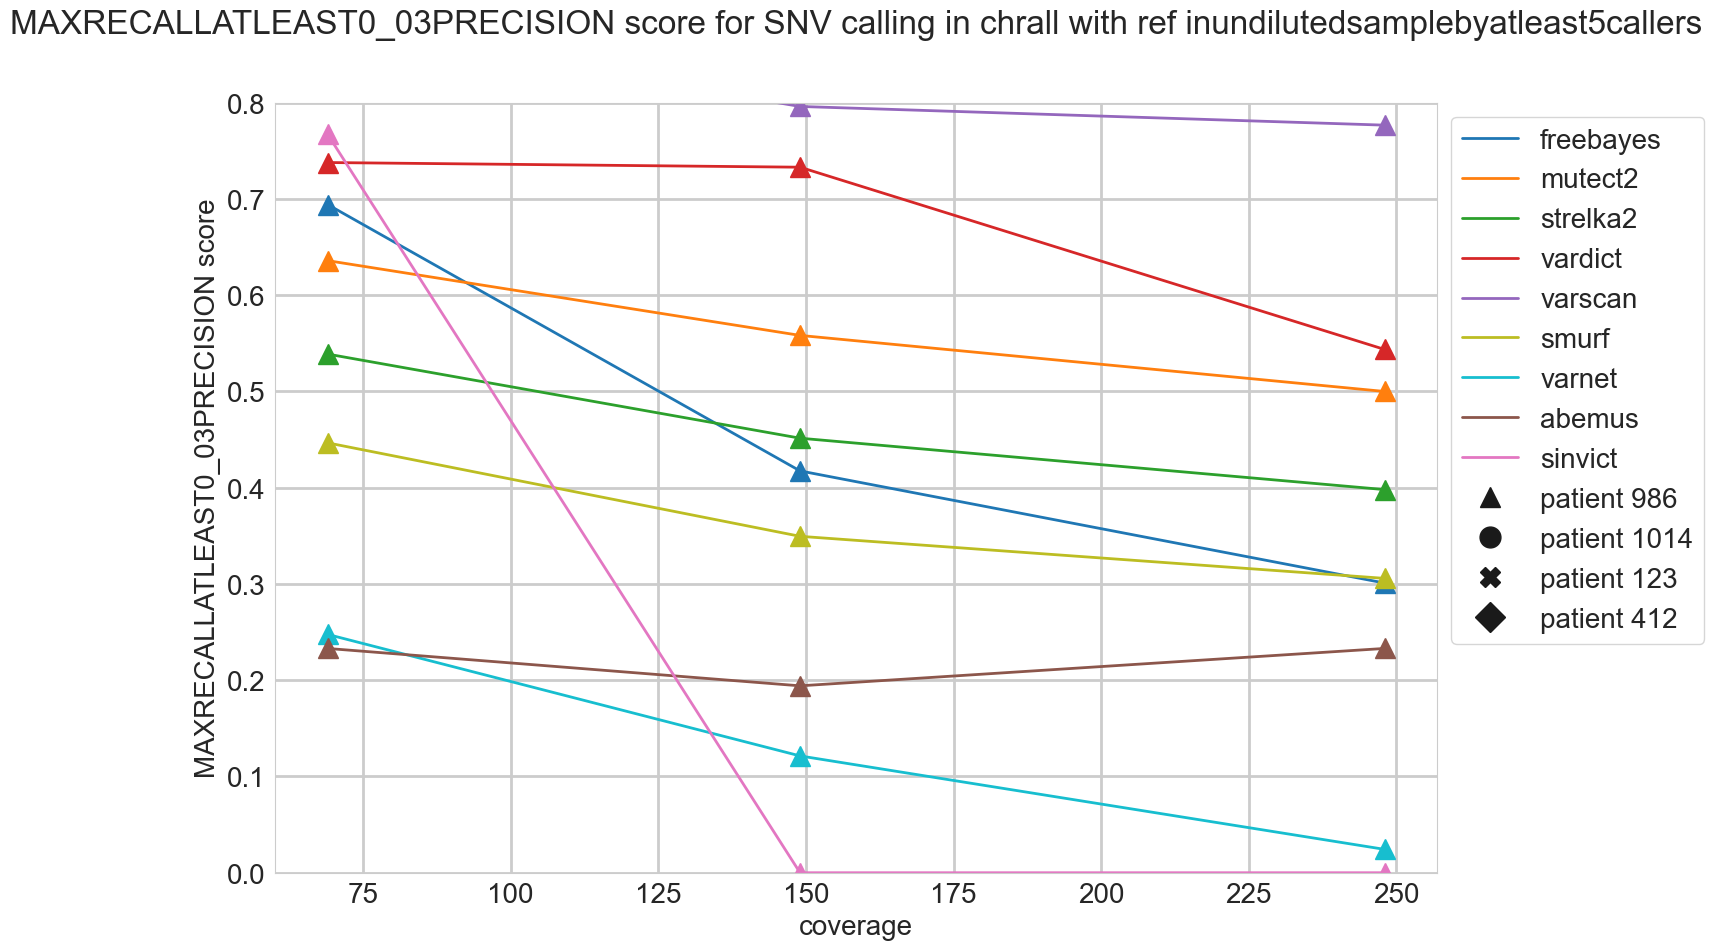

In [8]:
for fixedvar in fixedvars:
#fixedvar = 'coverage'
    if fixedvar == 'coverage':
        xaxis = 'tumor burden'
    elif fixedvar == 'ctdna':
        xaxis = 'coverage'
    #for mt in muttypes:
    mt = 'snv'
    if mt == 'snv':
        gtm = 5
        refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
    else:  # elif mt == 'indel':
        gtm = 2
        refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
    print(refname)
    # for metric in metrics:
    metric = 'maxrecallatleast0_03precision'#'auprc'
    # load results tables
    restables = {'snv': [], 'indel': []}
    mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
    #if mixtureid == 'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    #    gtm = 3
    #    refname = 'intissuesamplebyatleast'+str(gtm)+'callers'
    #else:
    #    gtm = 4
    refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
    plasmasample = '_'.join(mixtureid.split('_')[:2])
    print(mixtureid, plasmasample)
    xa = xaxis if xaxis != 'tumor burden' else 'tb'
    print(xa)
    restable = pd.read_csv(os.path.join(*config.mixturefolder, 'mixtures_allchr', 'results', mixtureid+'_'+mt+'_'+metric+'_'+refname+'_fixed'+fixedvar+'_'+ xa +'.csv'), index_col=0)
    #restable = pd.read_csv(os.path.join(*config.mixturefolder, 'mixtures_chr22_wgs', 'mixtures_chr22_'+mixtureid, 'results', mixtureid+'_'+mt+'_'+metric+'_'+refname+'_fixed'+fixedvar +'.csv'), index_col=0)
    restable['plasma sample'] = plasmasample
    restables[mt].append(restable)
    restables[mt] = pd.concat(restables[mt])
    res1 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
                       ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=True, logscale=False, save=False)
    #res2 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
    #                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=True, logscale=True, save=True)
    #res3 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
    #                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=False, save=True)
    #res4 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
    #                       ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=True, save=True)
    #plt.grid(linewidth=1)
    plt.ylim([0, .8])
    #plt.xlim([20, 0])
    #plt.xlim([40, 250])

inundilutedsamplebyatleast5callers
CRC-986_100215-CW-T_CRC-986_300316-CW-T
CRC-986_100215-CW-T_CRC-986_300316-CW-T CRC-986_100215-CW-T
tb
CRC-1014_180816-CW-T_CRC-1014_090516-CW-T
CRC-1014_180816-CW-T_CRC-1014_090516-CW-T CRC-1014_180816-CW-T
tb
CRC-123_310715-CW-T_CRC-123_121115-CW-T
CRC-123_310715-CW-T_CRC-123_121115-CW-T CRC-123_310715-CW-T
tb
BRA-412_240820-CW-T_BRA-412_060220-CW-T
BRA-412_240820-CW-T_BRA-412_060220-CW-T BRA-412_240820-CW-T
tb
tumor burden
CRC-986_100215-CW-T
CRC-1014_180816-CW-T
CRC-123_310715-CW-T
BRA-412_240820-CW-T


(0.0, 1.0)

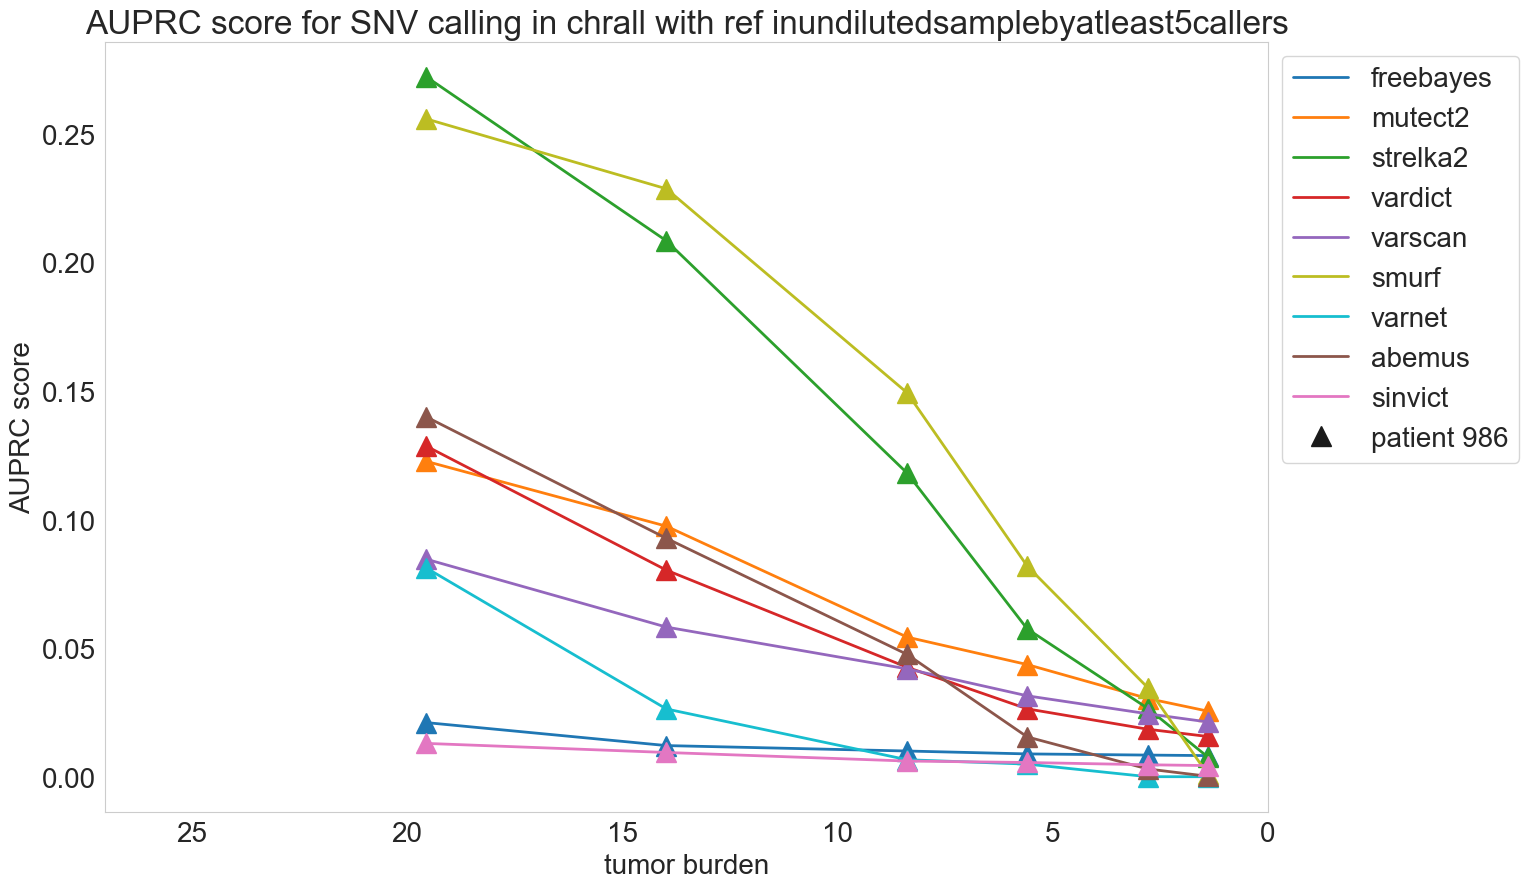

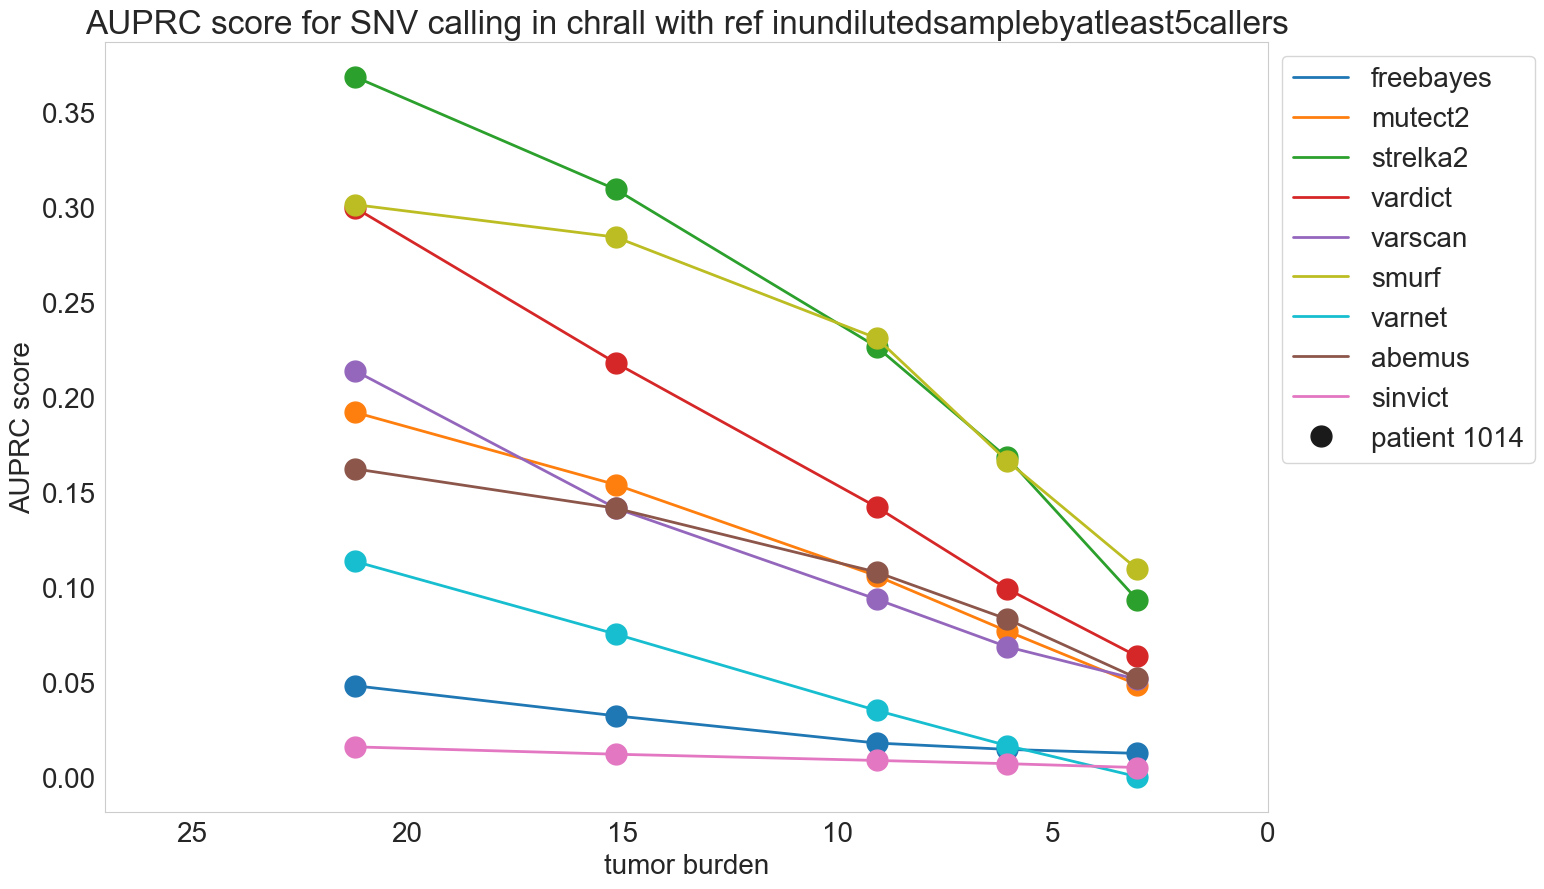

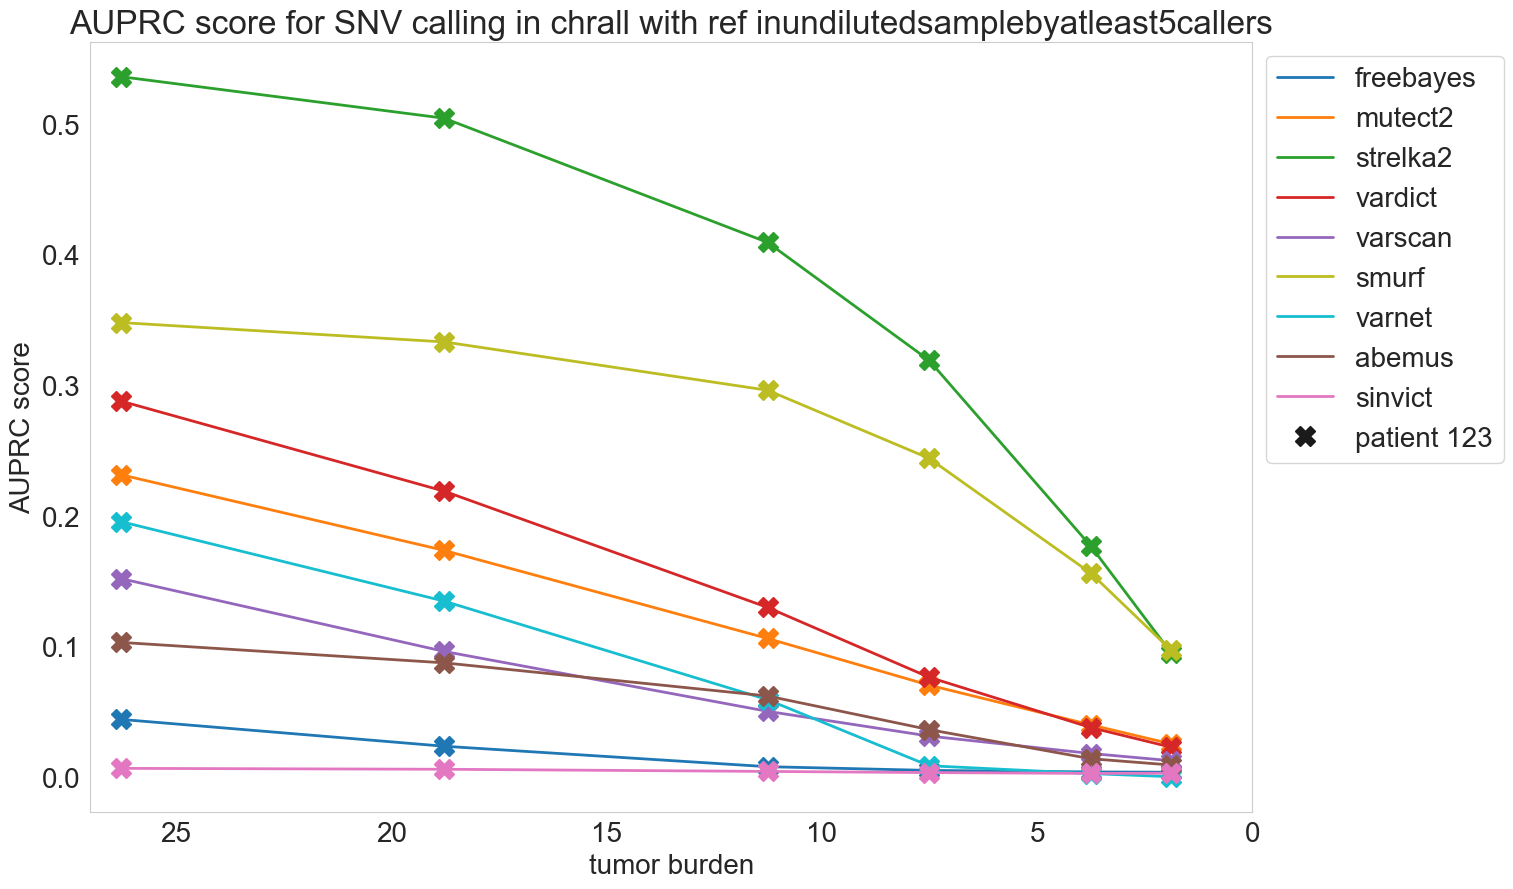

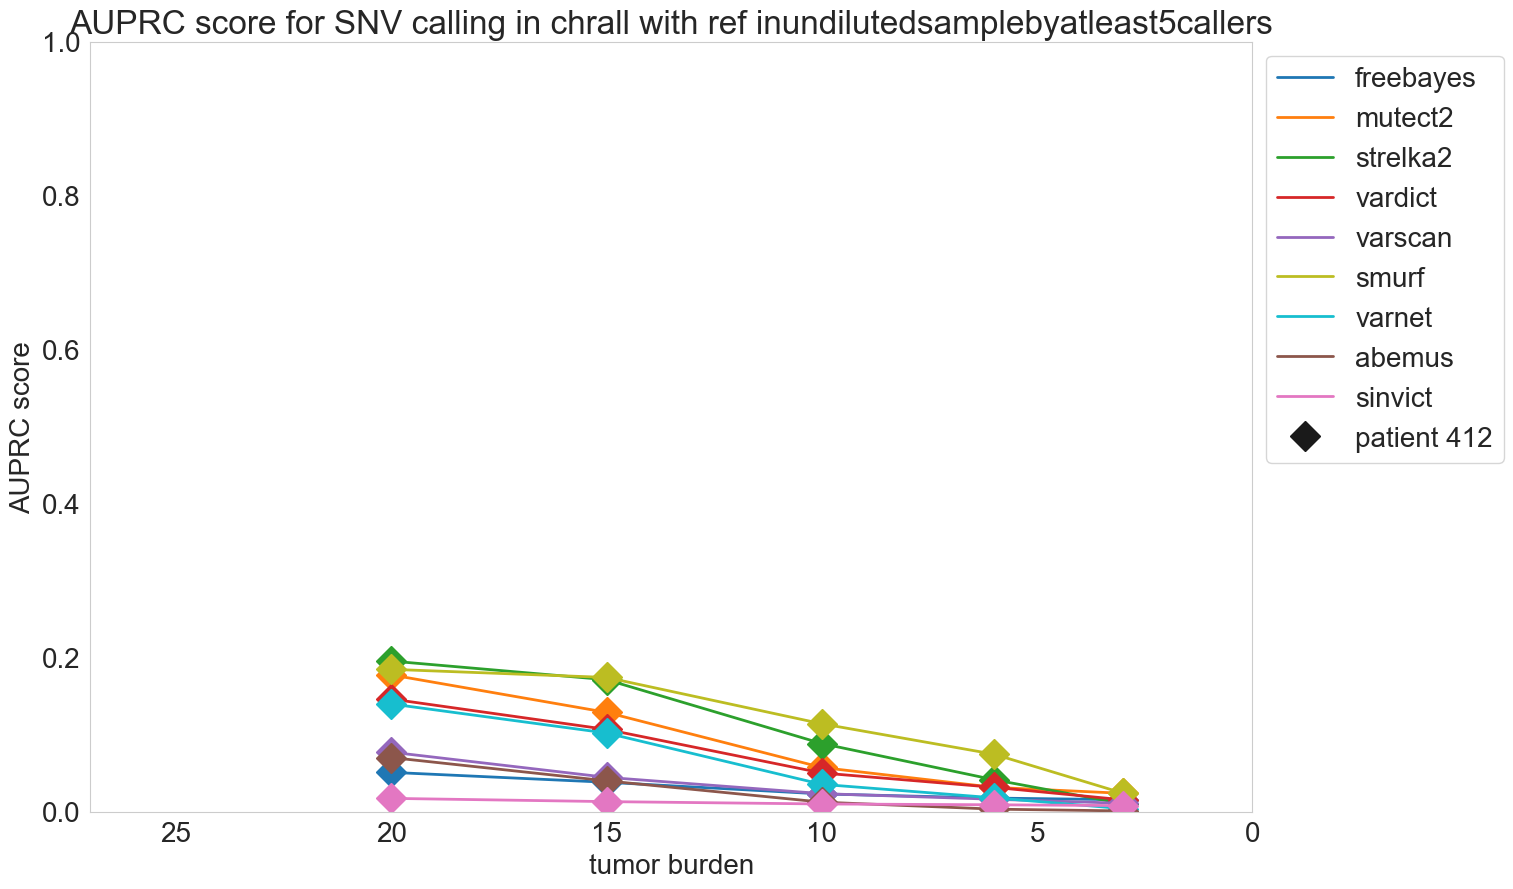

In [14]:
#for fixedvar in fixedvars:
fixedvar = 'coverage'
#fixedvar = 'ctdna'
if fixedvar == 'coverage':
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    xaxis = 'coverage'
#for mt in muttypes:
mt = 'snv'
if mt == 'snv':
    gtm = 5
    refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
else:  # elif mt == 'indel':
    gtm = 4
    refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
print(refname)
# for metric in metrics:
metric = 'auprc'
#metric = 'maxrecallatleast0_03precision'
# load results tables
restables = {'snv': [], 'indel': []}
for mixtureid in mixtureids:
    print(mixtureid)
    refname = 'inundilutedsamplebyatleast'+str(gtm)+'callers'
    plasmasample = '_'.join(mixtureid.split('_')[:2])
    print(mixtureid, plasmasample)
    xa = xaxis if xaxis != 'tumor burden' else 'tb'
    print(xa)
    restable = pd.read_csv(os.path.join(*config.mixturefolder, 'mixtures_allchr', 'results', mixtureid+'_'+mt+'_'+metric+'_'+refname+'_fixed'+fixedvar+'_'+ xa +'.csv'), index_col=0)
    #restable = pd.read_csv(os.path.join(*config.mixturefolder, 'mixtures_chr22_wgs', 'mixtures_chr22_'+mixtureid, 'results', mixtureid+'_'+mt+'_'+metric+'_'+refname+'_fixed'+fixedvar +'.csv'), index_col=0)
    restable['plasma sample'] = plasmasample
    restables[mt].append(restable)
restables[mt] = pd.concat(restables[mt])
res1 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=False, save=False)
plt.ylim([0, 1])
#res1 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=True, logscale=False, save=False)
#res2 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=True, logscale=True, save=True)
#res3 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                   ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=False, save=True)
#res4 = plot_metricsseries(config, restables, mixtureids, 'all', metric=metric, muttype=mt,
#                       ground_truth_method='mixture', fixedvar=fixedvar, refname=refname, allpatients=False, logscale=True, save=True)

In [11]:
tfdict = {'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T': [40.3, 3.2], 
         'CRC-123_310715-CW-T_CRC-123_121115-CW-T': [62.1, 2.2],
         'CRC-986_100215-CW-T_CRC-986_300316-CW-T': [32.6, 0]}

for mi, mixtureid in enumerate(mixtureids):
    print(mixtureid)
    seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    print(seriesorder)
    esttflist = []
    for s in seriesorder[1:]:
        sh, sl = s
        esttf = round((tfdict[mixtureid][0]*sh + tfdict[mixtureid][1]*sl)/(sl+sh), 2)
        print(esttf)
        esttflist.append(esttf)
    esttflist = [esttflist] * len(config.methods)
    print(esttflist)
    resx[mi*len(config.methods):(mi+1)*len(config.methods), :] = esttflist

CRC-986_100215-CW-T_CRC-986_300316-CW-T
[(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
15.21
10.87
6.52
4.35
2.17
1.09
[[15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09], [15.21, 10.87, 6.52, 4.35, 2.17, 1.09]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [198]:
#resx = np.array([rx.values for rx in res1['x']])
#resx[resx.shape[0]-len(config.methods):] = [np.append(a, np.nan) for a in resx[resx.shape[0]-len(config.methods):]]# brca 5 samples instead of 6
#resx = pd.DataFrame(list(resx)).mean(axis=0).values
#resy = np.array([ry.values for ry in res1['y']])
#resy[resy.shape[0]-len(config.methods):] = [np.append(a, np.nan) for a in resy[resy.shape[0]-len(config.methods):]]# brca 5 samples instead of 6

#res = {m: [] for m in config.methods}
#for mi, m in enumerate(config.methods):
#    resmean = np.mean([resy[mi], resy[mi+len(config.methods)], resy[mi+2*len(config.methods)]], axis=0)
#    resstd = np.std([resy[mi], resy[mi+len(config.methods)], resy[mi+2*len(config.methods)]], axis=0)
#    #reslabel = m
#    res[m] = [resmean, resstd, pd.DataFrame(list(resx)).mean(axis=0).values]

In [56]:
resx = np.array([rx.values for rx in res1['x']])
resx[resx.shape[0]-len(config.methods):] = [np.append(a, np.nan) for a in resx[resx.shape[0]-len(config.methods):]]# brca 5 samples instead of 6
meanresx = pd.DataFrame(list(resx)).mean(axis=0).values
stdresx = pd.DataFrame(list(resx)).std(axis=0).values

resy = np.array([ry.values for ry in res1['y']])
for i in range(len(config.methods)):
    resy[len(config.methods)*3 + i ] = np.array(list(resy[len(config.methods)*3 + i ]) + [np.nan]) # brca 5 samples instead of 6
    resy[len(config.methods)*1 + i ] = np.array(list(resy[len(config.methods)*1 + i ]) + [np.nan]) # brca 5 samples instead of 6
resy = resy.reshape(len(mixtureids),len(config.methods))#, 3), # 3) # 
meanresy = []
stdresy = []
for mi in range(len(config.methods)):
    tmp = {}
    for si in range(len(mixtureids)):
        tmp[mixtureids[si]] = (list(resy[si][mi]))
    tmpdf = pd.DataFrame.from_dict(tmp)
    meanresy.append(tmpdf.mean(axis=1).values)
    stdresy.append(tmpdf.std(axis=1).values)

In [58]:
if fixedvar == 'coverage':
    allmetrics = pd.DataFrame()
    for mixtureid in mixtureids:
        print(mixtureid)
        allmetrics = pd.concat([allmetrics, pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', mixtureid+'_tf_cov_maxmetric.csv'), index_col=0).reset_index()[['maxmetric']]], axis=1)
    allmetrics = allmetrics.iloc[1:]
    print(allmetrics)
    print(allmetrics.mean(axis=1))
    print(allmetrics.std(axis=1))

else: #fixedvar = tf
    allmetrics = pd.DataFrame()
    for mixtureid in mixtureids:
        print(mixtureid)
        allmetrics = pd.concat([allmetrics, pd.read_csv(os.path.join('data', 'mixtures', 'mixtures_allchr', mixtureid+'_tf_cov_maxmetric.csv'), index_col=0).reset_index()[['maxmetric']]], axis=1)
    allmetrics = pd.DataFrame(allmetrics.iloc[1])
    print(allmetrics)
    print(allmetrics.mean(axis=1))
    print(allmetrics.std(axis=1))

CRC-986_100215-CW-T_CRC-986_300316-CW-T
CRC-1014_180816-CW-T_CRC-1014_090516-CW-T
CRC-123_310715-CW-T_CRC-123_121115-CW-T
BRA-412_240820-CW-T_BRA-412_060220-CW-T
   maxmetric  maxmetric  maxmetric  maxmetric
1   0.995146   1.000000   1.000000   0.996491
2   0.990291   0.997230   0.997792   0.992982
3   0.946602   0.966759   0.986755   0.968421
4   0.873786   0.927978   0.958057   0.926316
5   0.796117   0.867036   0.867550   0.898246
6   0.728155   0.817175   0.801325        NaN
1    0.997909
2    0.994574
3    0.967134
4    0.921534
5    0.857237
6    0.782218
dtype: float64
1    0.002476
2    0.003572
3    0.016415
4    0.035015
5    0.043281
6    0.047486
dtype: float64


0
1
2
3
4
5
6
7
8


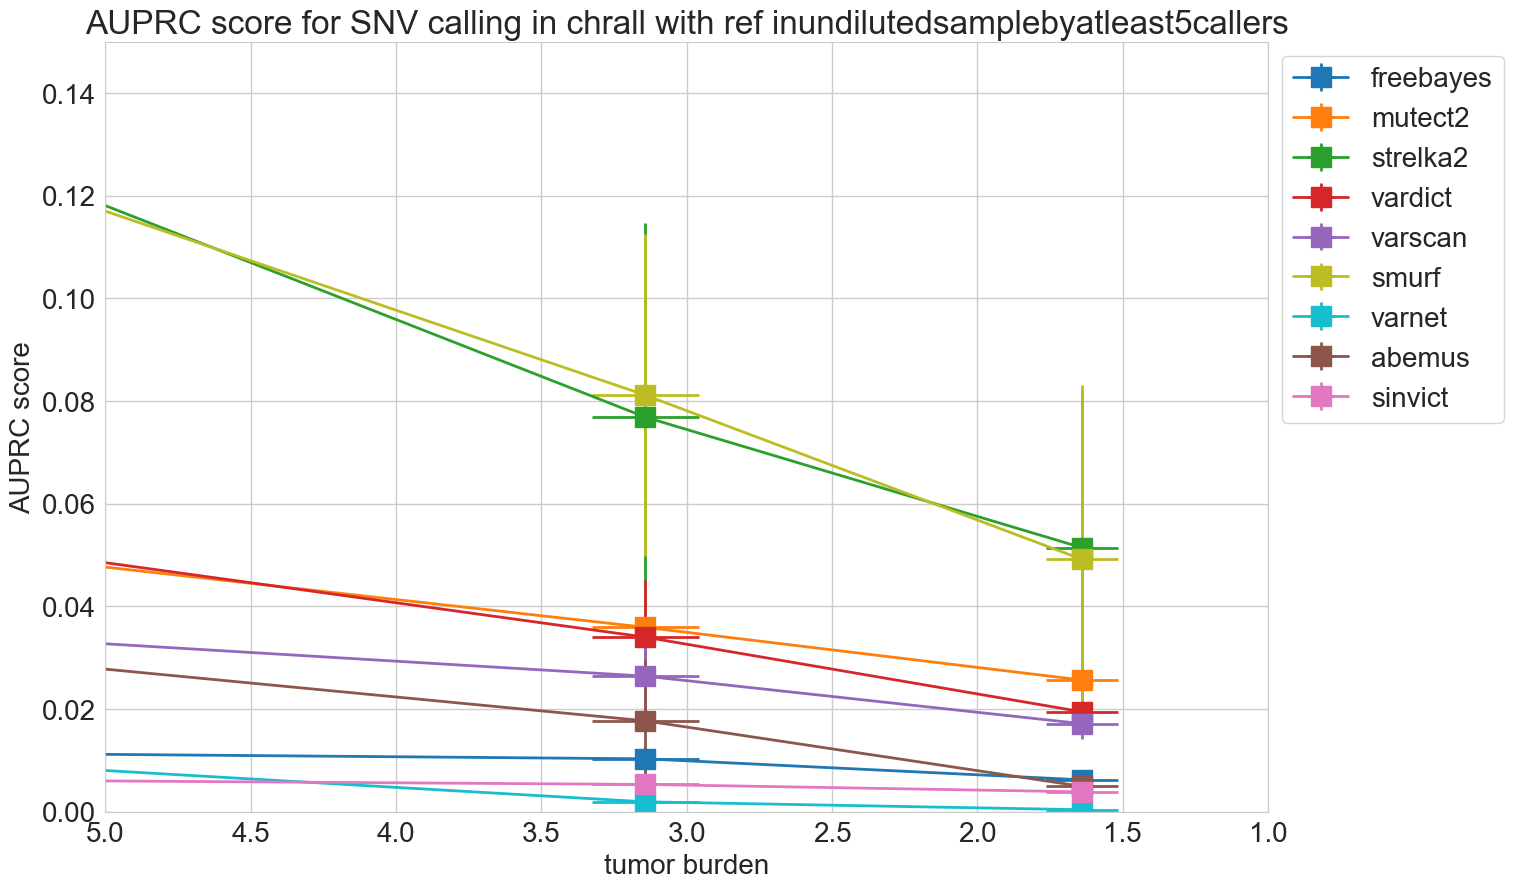

In [62]:
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(15, 10))
plt.grid(linewidth=1)
plt.grid()
#for m in config.methods:
    #print(m)
    #plt.plot(res['freebayes'][2], res['freebayes'][0], c=color_dict['freebayes'], markersize=15, lw=2)
    #plt.errorbar(res[m][2], res[m][0], xerr = resx.std(axis=0)/np.sqrt(int(resx.shape[0]/(len(config.methods)))), yerr=res[m][1]/int(resx.shape[0]/(len(config.methods))), marker='s',  c=color_dict[m], label=m,  markersize=15, lw=2, fmt='-o')
    #plt.errorbar(res[m][2], res[m][0], xerr = pd.DataFrame(list(resx)).std(axis=0).values/np.sqrt(int(pd.DataFrame(list(resx)).shape[0]/(len(config.methods)))), yerr=res[m][1]/int(resx.shape[0]/(len(config.methods))), marker='s',  c=color_dict[m], label=m,  markersize=15, lw=2, fmt='-o')
for mi in range(len(config.methods)):
    print(mi)
    #plt.errorbar(meanresx, meanresy[mi], xerr = stdresx/[2, 2, 2, 2, 2, np.sqrt(3)], yerr=stdresy[mi]/[2, 2, 2, 2, 2, np.sqrt(3)], marker='s',  c=color_dict[config.methods[mi]], label=config.methods[mi],  markersize=15, lw=2, fmt='-o')
    plt.errorbar(meanresx, meanresy[mi], xerr = stdresx/np.sqrt(4), yerr=stdresy[mi]/np.sqrt(4), marker='s',  c=color_dict[config.methods[mi]], label=config.methods[mi],  markersize=15, lw=2, fmt='-o')
ax = plt.gca()
if fixedvar == 'coverage':
    plt.gca().invert_xaxis()
    xlab='tumor burden'
else:
    xlab = 'coverage or added noise'
#plt.errorbar(meanresx, allmetrics.mean(axis=1).values, xerr = stdresx/[2, 2, 2, 2, 2, np.sqrt(3)], yerr=allmetrics.std(axis=1)/[2, 2, 2, 2, 2, np.sqrt(3)], c='k', marker='o', ms=7, ls='--', label='max sensitivity')
#plt.errorbar(meanresx, 3*[allmetrics.mean().values[0]], xerr = stdresx/np.sqrt(4), yerr=3*[allmetrics.std().values[0]/np.sqrt(4)], c='k', marker='o', ms=7, ls='--', label='max sensitivity')
hand, labl = ax.get_legend_handles_labels()
ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel(xlab)
plt.ylabel(metric.upper()+' score')
plt.grid()
plt.title(metric.upper() + " score for {} calling in chr{} with ref {}".format(mt.upper(), chrom, refname))
plt.ylim([0,0.15])
plt.xlim([5,1])
#plt.ylim([0,1])
plt.savefig('/Users/hanae/Desktop/Figure3_auprc_seriesB_zoom.svg', bbox_inches='tight')
plt.savefig('/Users/hanae/Desktop/Figure3_auprc_seriesB_zoom.png', bbox_inches='tight')

In [29]:
#meanresx
allmetrics.mean(axis=1).values

array([0.99790921, 0.99457403, 0.96713424, 0.92153436, 0.85723695,
       0.78221812])

0
1
2
3
4
5
6
7
8


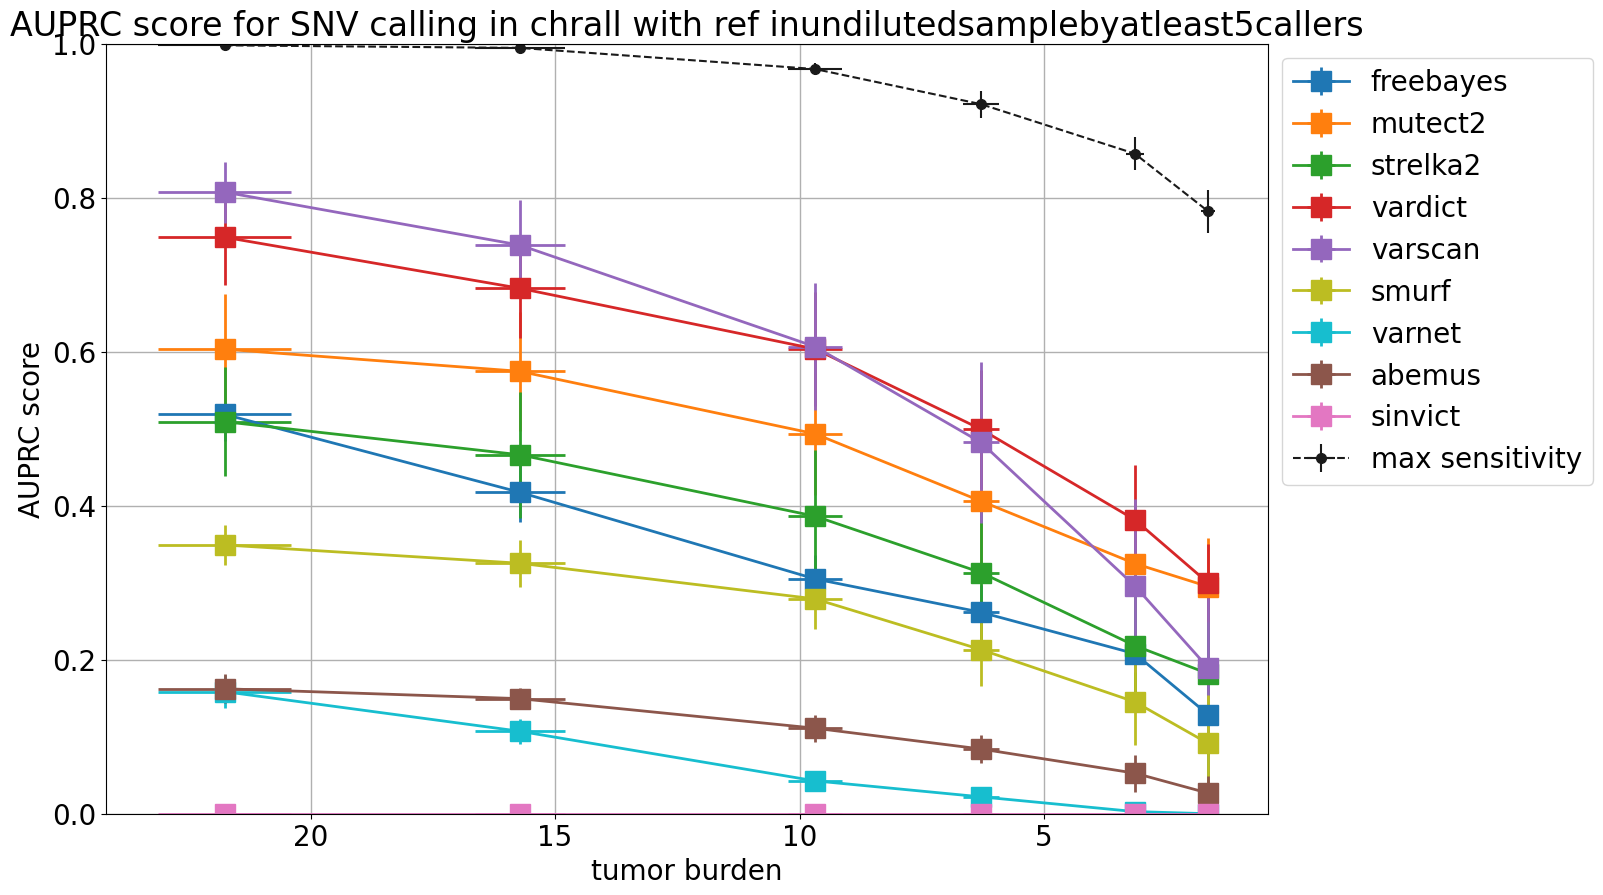

In [44]:
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(15, 10))
plt.grid(linewidth=1)
plt.grid()
#for m in config.methods:
    #print(m)
    #plt.plot(res['freebayes'][2], res['freebayes'][0], c=color_dict['freebayes'], markersize=15, lw=2)
    #plt.errorbar(res[m][2], res[m][0], xerr = resx.std(axis=0)/np.sqrt(int(resx.shape[0]/(len(config.methods)))), yerr=res[m][1]/int(resx.shape[0]/(len(config.methods))), marker='s',  c=color_dict[m], label=m,  markersize=15, lw=2, fmt='-o')
    #plt.errorbar(res[m][2], res[m][0], xerr = pd.DataFrame(list(resx)).std(axis=0).values/np.sqrt(int(pd.DataFrame(list(resx)).shape[0]/(len(config.methods)))), yerr=res[m][1]/int(resx.shape[0]/(len(config.methods))), marker='s',  c=color_dict[m], label=m,  markersize=15, lw=2, fmt='-o')
for mi in range(len(config.methods)):
    print(mi)
    plt.errorbar(meanresx, meanresy[mi], xerr = stdresx/[2, 2, 2, 2, 2, np.sqrt(3)], yerr=stdresy[mi]/[2, 2, 2, 2, 2, np.sqrt(3)], marker='s',  c=color_dict[config.methods[mi]], label=config.methods[mi],  markersize=15, lw=2, fmt='-o')
    #plt.errorbar(meanresx, meanresy[mi], xerr = stdresx/np.sqrt(4), yerr=stdresy[mi]/np.sqrt(4), marker='s',  c=color_dict[config.methods[mi]], label=config.methods[mi],  markersize=15, lw=2, fmt='-o')
ax = plt.gca()
if fixedvar == 'coverage':
    plt.gca().invert_xaxis()
    xlab='tumor burden'
else:
    xlab = 'coverage or added noise'
plt.errorbar(meanresx, allmetrics.mean(axis=1).values, xerr = stdresx/[2, 2, 2, 2, 2, np.sqrt(3)], yerr=allmetrics.std(axis=1)/[2, 2, 2, 2, 2, np.sqrt(3)], c='k', marker='o', ms=7, ls='--', label='max sensitivity')
hand, labl = ax.get_legend_handles_labels()
ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel(xlab)
plt.ylabel(metric.upper()+' score')
plt.grid()
plt.title(metric.upper() + " score for {} calling in chr{} with ref {}".format(mt.upper(), chrom, refname))
#plt.ylim([0,0.5])
plt.ylim([0,1])
#plt.savefig('/Users/hanae/Desktop/Figure3_maxrecall.svg', bbox_inches='tight')
#plt.savefig('/Users/hanae/Desktop/Figure3_maxrecall.png', bbox_inches='tight')

(0.0, 0.5)

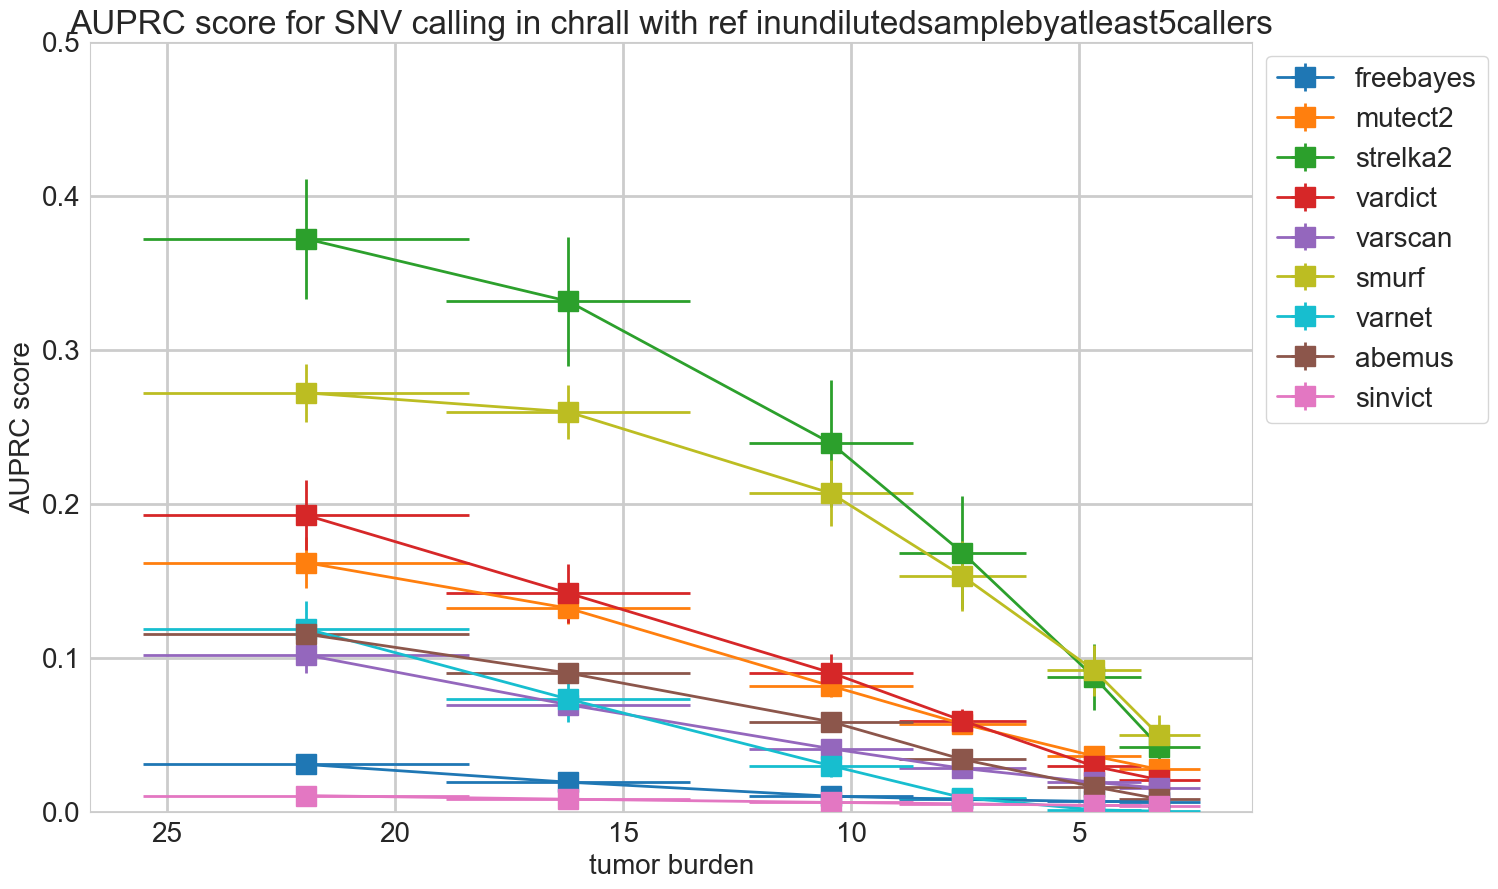

In [59]:
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
plt.figure(figsize=(15, 10))
#plt.grid(linewidth=1)
plt.grid()
for m in config.methods:
    #plt.plot(res['freebayes'][2], res['freebayes'][0], c=color_dict['freebayes'], markersize=15, lw=2)
    plt.errorbar(res[m][2], res[m][0], xerr = resx.std(axis=0)/np.sqrt(int(resx.shape[0]/(len(config.methods)))), yerr=res[m][1]/int(resx.shape[0]/(len(config.methods))), marker='s',  c=color_dict[m], label=m,  markersize=15, lw=2, fmt='-o')
ax = plt.gca()
if fixedvar == 'coverage':
    plt.gca().invert_xaxis()
    xlab='tumor burden'
else:
    xlab = 'coverage or added noise'
hand, labl = ax.get_legend_handles_labels()
ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel(xlab)
plt.ylabel(metric.upper()+' score')
plt.grid()
plt.title(metric.upper() + " score for {} calling in chr{} with ref {}".format(mt.upper(), chrom, refname))
plt.ylim([0,0.5])

In [ ]:
for m in config.methods:
    res[m][2] = res[m][2][::-1]
    res[m][0] = res[m][0][::-1]
    res[m][1] = res[m][1][::-1]

In [ ]:
#color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
#plt.figure(figsize=(15, 10))
#plt.grid(linewidth=1)
#res[m][2] = res[m][2][::-1]
#res[m][0] = res[m][0][::-1]
#res[m][1] = res[m][1][::-1]
rankres = []
for m in config.methods:
    xstart = 0
    ystart = 0
    sum_all = []
    for i in range(len(res[m][2])):
        #if i >0:
        #print(res[m][2][i], xstart)
        #print((res[m][2][i]-xstart) * res[m][0][i] )
        #print(((res[m][2][i]-xstart) * (res[m][0][i]-ystart)/2))
        sum_all.append(((res[m][2][i]-xstart) * res[m][0][i]) - ((res[m][2][i]-xstart) * (res[m][0][i]-ystart)/2))
        xstart = res[m][2][i]
        ystart = res[m][0][i]
    print(m, np.sum(sum_all) )
    rankres.append(np.sum(sum_all))
    #plt.plot(res['freebayes'][2], res['freebayes'][0], c=color_dict['freebayes'], markersize=15, lw=2)
    #plt.errorbar(res[m][2], res[m][0], xerr = resx.std(axis=0), yerr=res[m][1], marker=config.markers[0], label=m,  markersize=15, lw=2, fmt='-o')
    #plt.gca().invert_xaxis()
#ax = plt.gca()
#xlab = 'coverage or added noise'
#xlab='tumor burden'
#hand, labl = ax.get_legend_handles_labels()
#ax.legend(hand, labl, bbox_to_anchor=(1, 1), loc="upper left")
#plt.xlabel(xlab)
#plt.ylabel(metric.upper()+' score')
#plt.title(metric.upper() + " score for {} calling in chr{} with ref {}".format(mt.upper(), chrom, refname))

In [ ]:
import matplotlib.patches as mpatches
rankres_sort = np.argsort(rankres)[::-1]
rankres_sort
plt.figure(figsize=(14, 5))
method_order =[]
rank_order =[]
for i in rankres_sort:
    method_order.append(config.methods[i])
    rank_order.append(rankres[i])
plt.bar(method_order, rank_order, color=['b', 'b', 'b', 'b', 'b', 'r', 'r'])
blue_patch = mpatches.Patch(color='b', label='DNA methods')
red_patch = mpatches.Patch(color='r', label='cfDNA methods')
plt.legend(handles=[blue_patch, red_patch])
#plt.legend(['DNA methods', 'cfDNA methods'])
plt.ylabel('area under AUPRC curve')
plt.title('Caller ranking mixtures with decreasing tumor burden')

In [148]:
save

False

['mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_0x', 'mixture_BRA-412_240820-CW-T_70x_BRA-412_060220-CW-T_30x', 'mixture_BRA-412_240820-CW-T_50x_BRA-412_060220-CW-T_50x', 'mixture_BRA-412_240820-CW-T_30x_BRA-412_060220-CW-T_70x', 'mixture_BRA-412_240820-CW-T_20x_BRA-412_060220-CW-T_80x', 'mixture_BRA-412_240820-CW-T_10x_BRA-412_060220-CW-T_90x']
40.00_freebayes_score
Index([], dtype='object', name='chrom_pos_ref_alt')
before [1.         0.68070175 0.67719298 ... 0.         0.         0.        ] [4.98587336e-04 1.23645634e-01 1.23086735e-01 ... 0.00000000e+00
 0.00000000e+00 1.00000000e+00]
20.00_freebayes_score
Index([], dtype='object', name='chrom_pos_ref_alt')
before [1.         0.55789474 0.55789474 ... 0.         0.         0.        ] [4.98587336e-04 1.04262295e-01 1.04330709e-01 ... 0.00000000e+00
 0.00000000e+00 1.00000000e+00]
15.00_freebayes_score
Index([], dtype='object', name='chrom_pos_ref_alt')
before [1.         0.49122807 0.4877193  ... 0.         0.         0.  

{'mixture_BRA-412_240820-CW-T_100x_BRA-412_060220-CW-T_0x': {'freebayes': [array([1.        , 0.68070175, 0.67719298, ..., 0.        , 0.        ,
          0.        ]),
   array([4.98587336e-04, 1.23645634e-01, 1.23086735e-01, ...,
          0.00000000e+00, 0.00000000e+00, 1.00000000e+00])],
  'mutect2': [array([1.        , 0.53684211, 0.53684211, 0.53684211, 0.53684211,
          0.53684211, 0.53684211, 0.53684211, 0.53684211, 0.53684211,
          0.53684211, 0.53684211, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333,
          0.53333333, 0.53333333, 0.53333333, 0.53333333, 0.5333

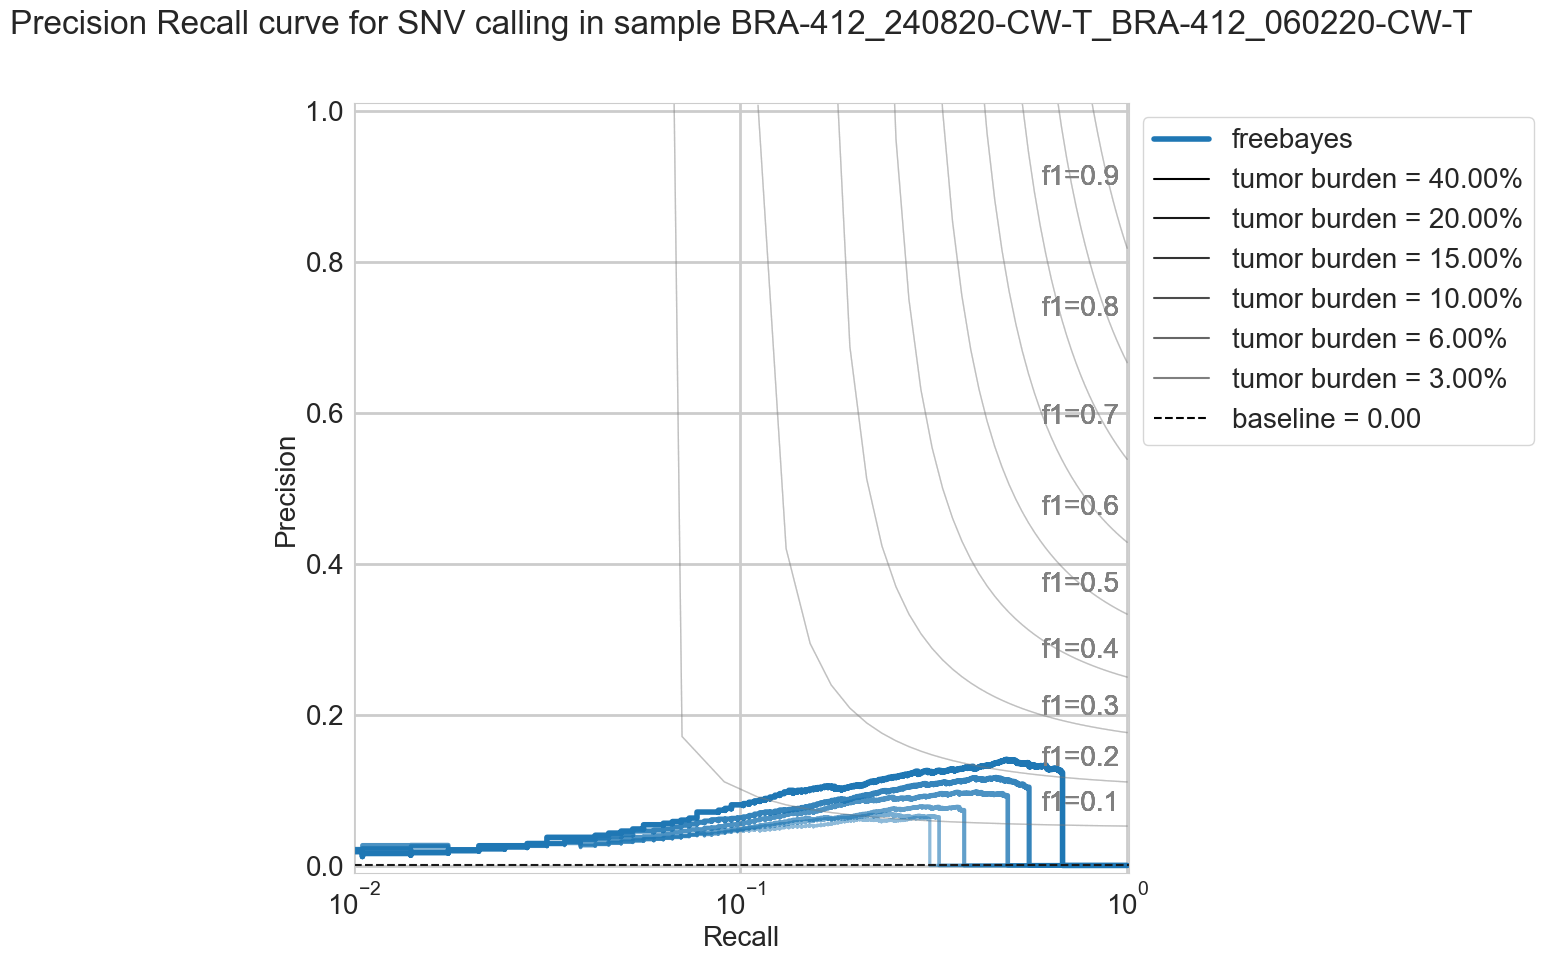

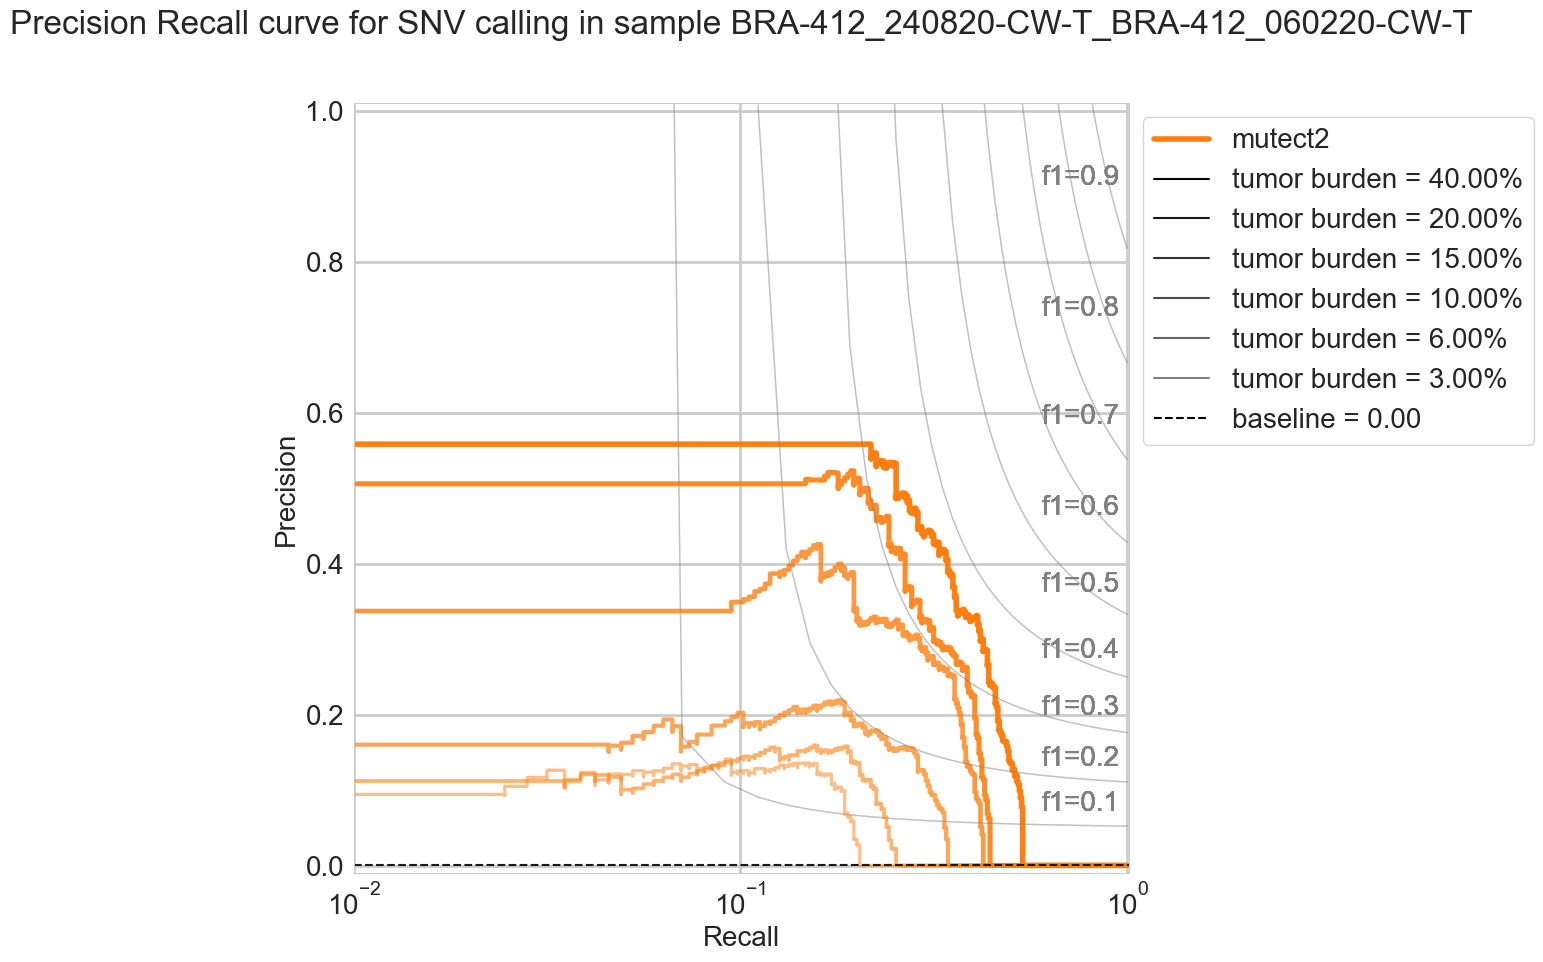

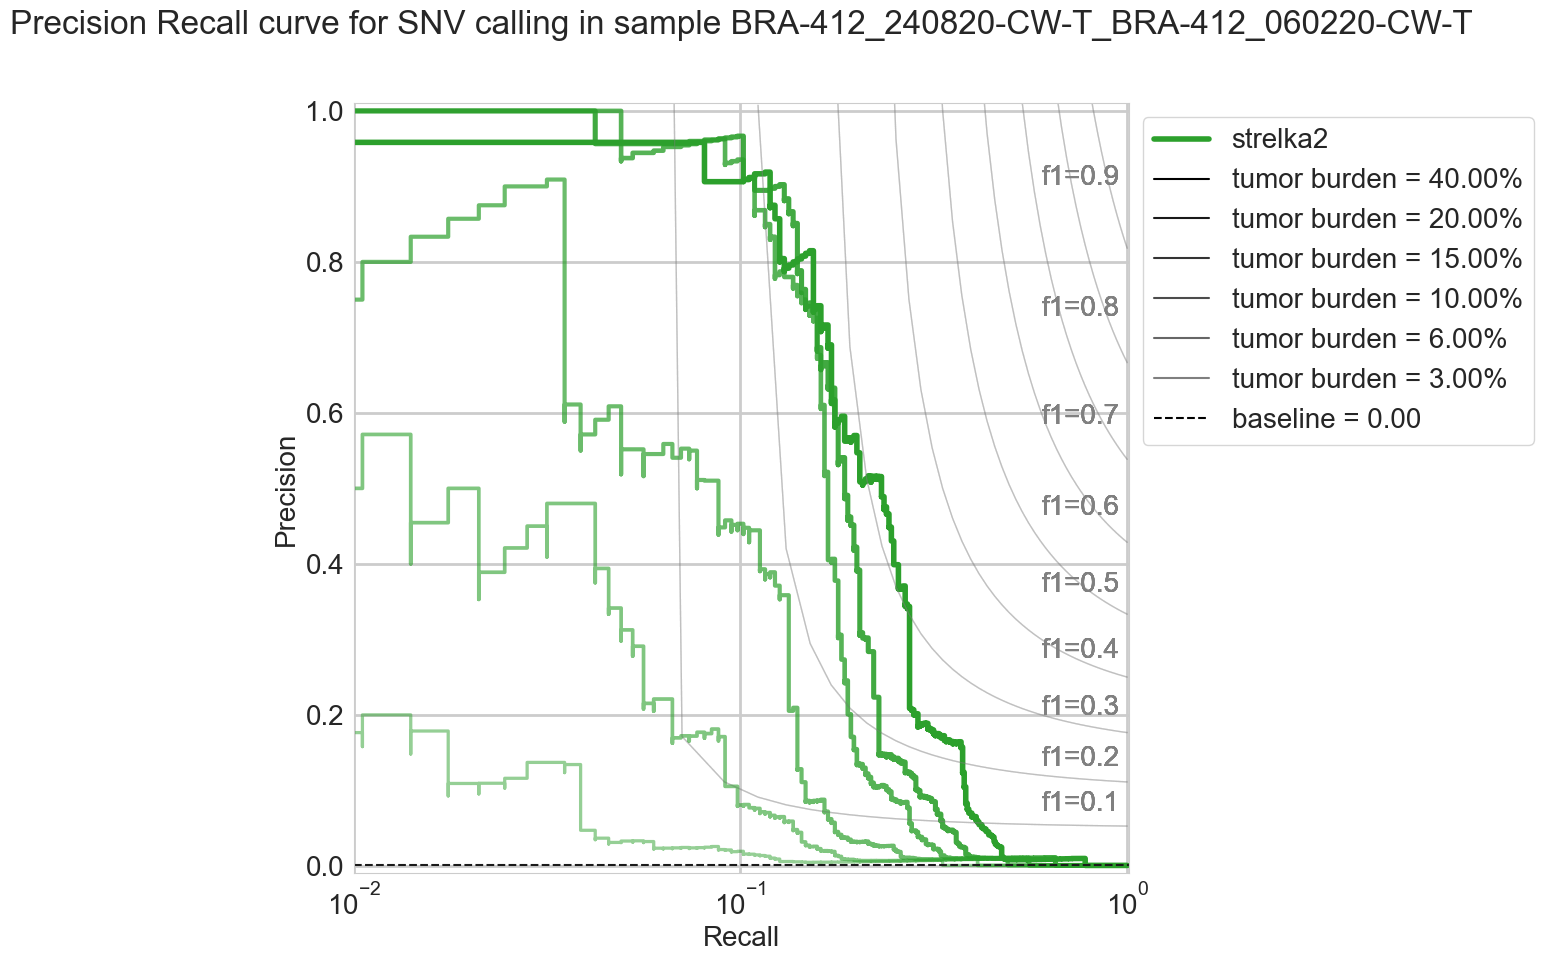

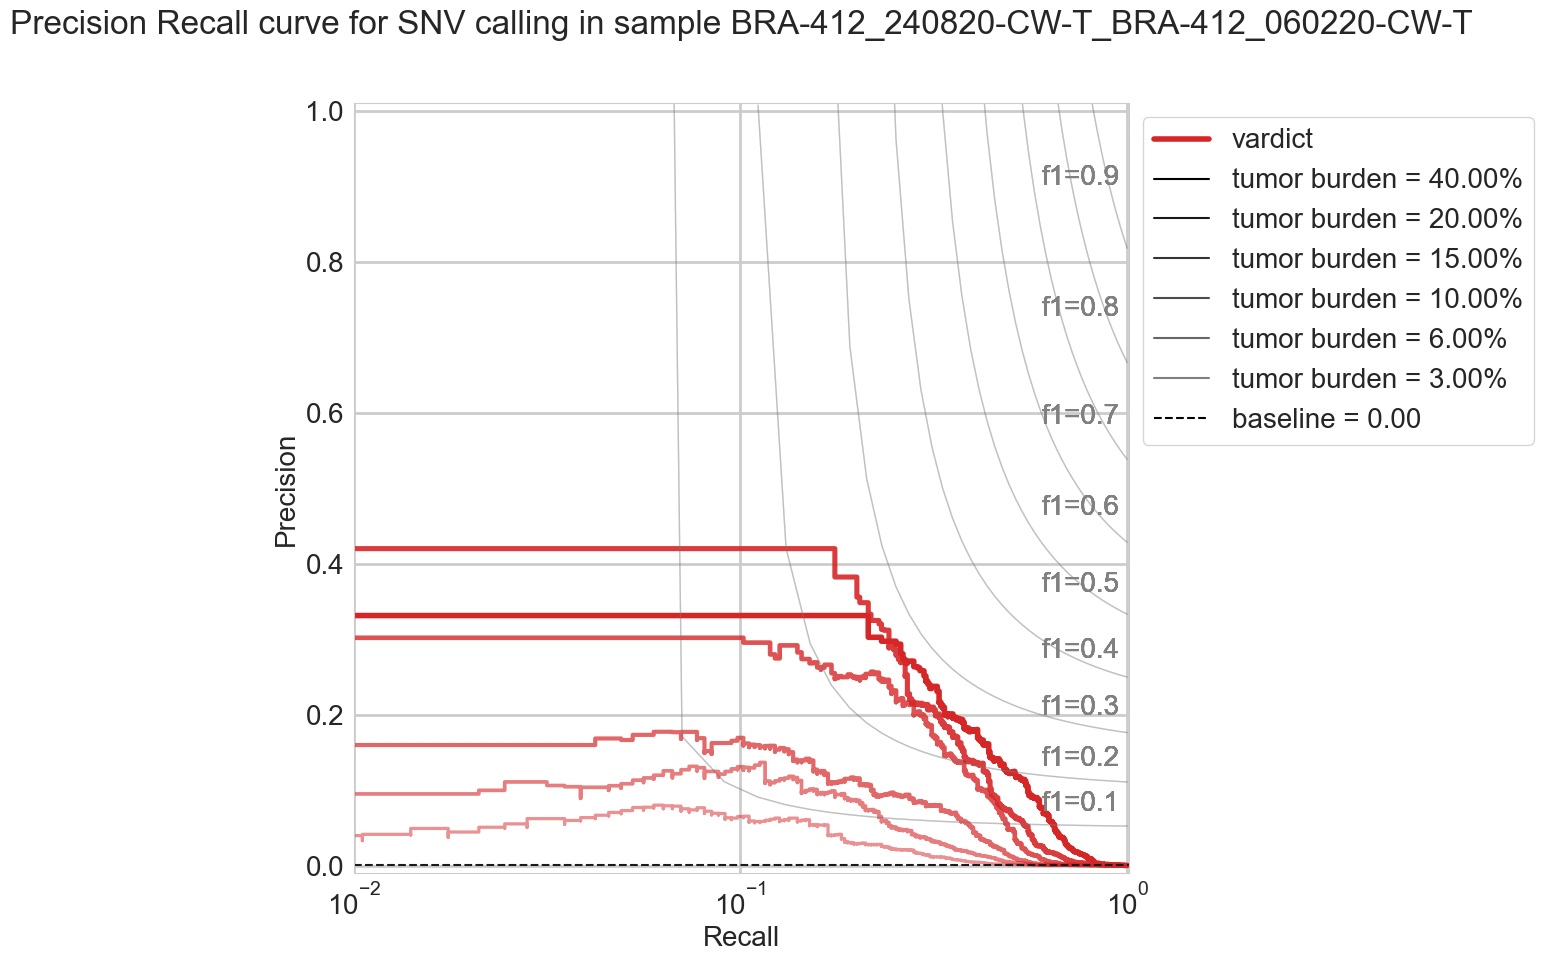

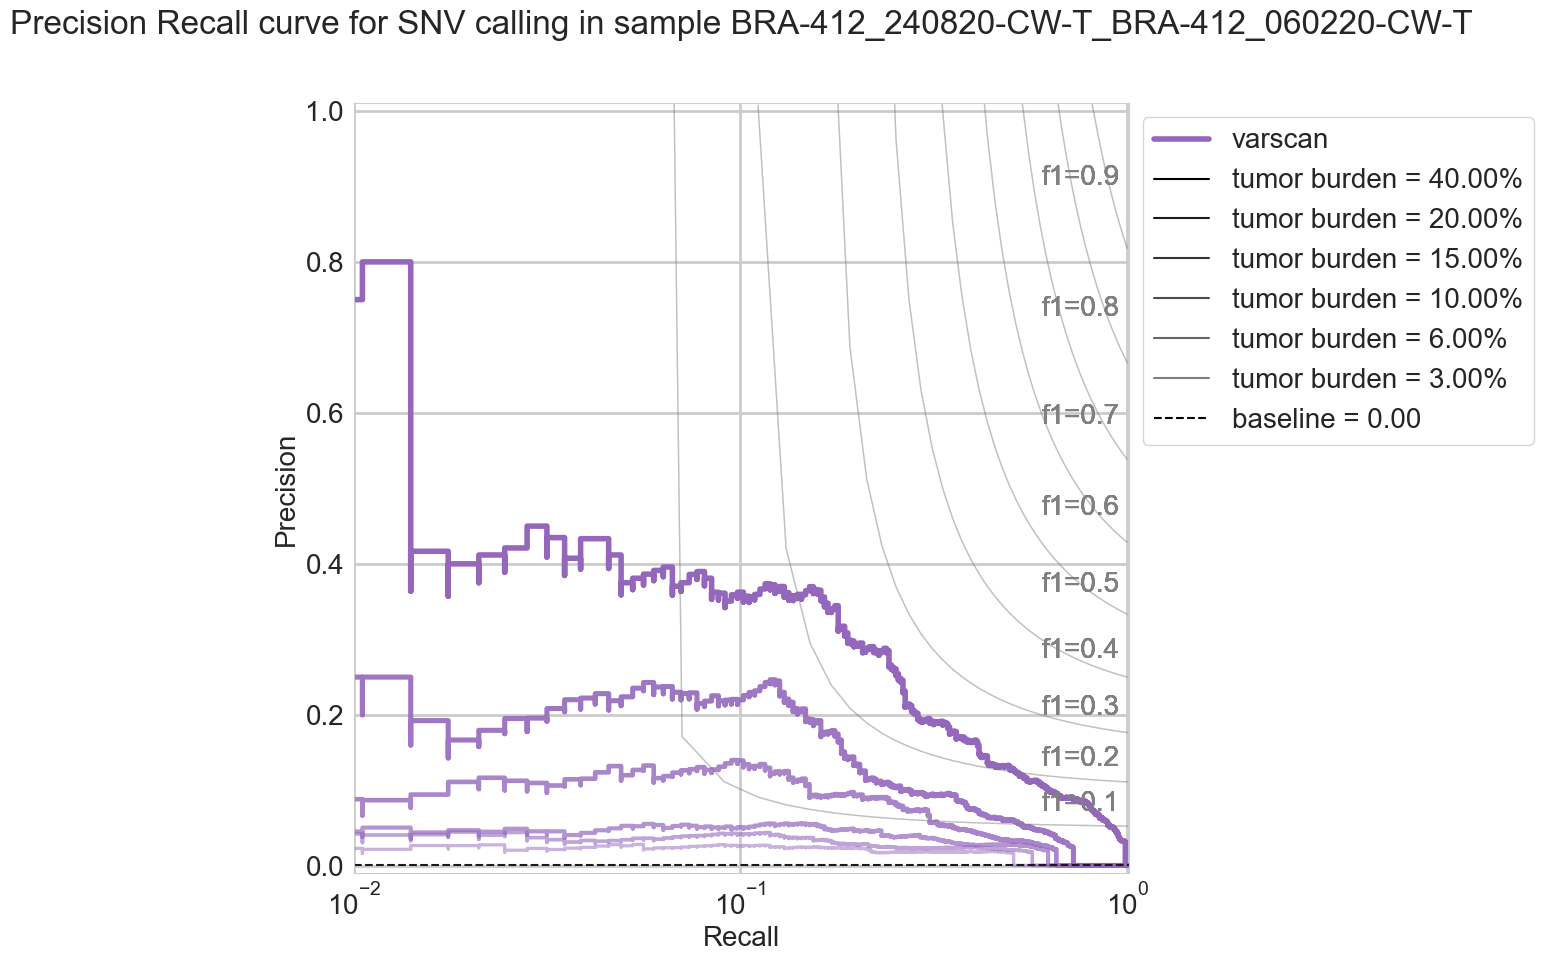

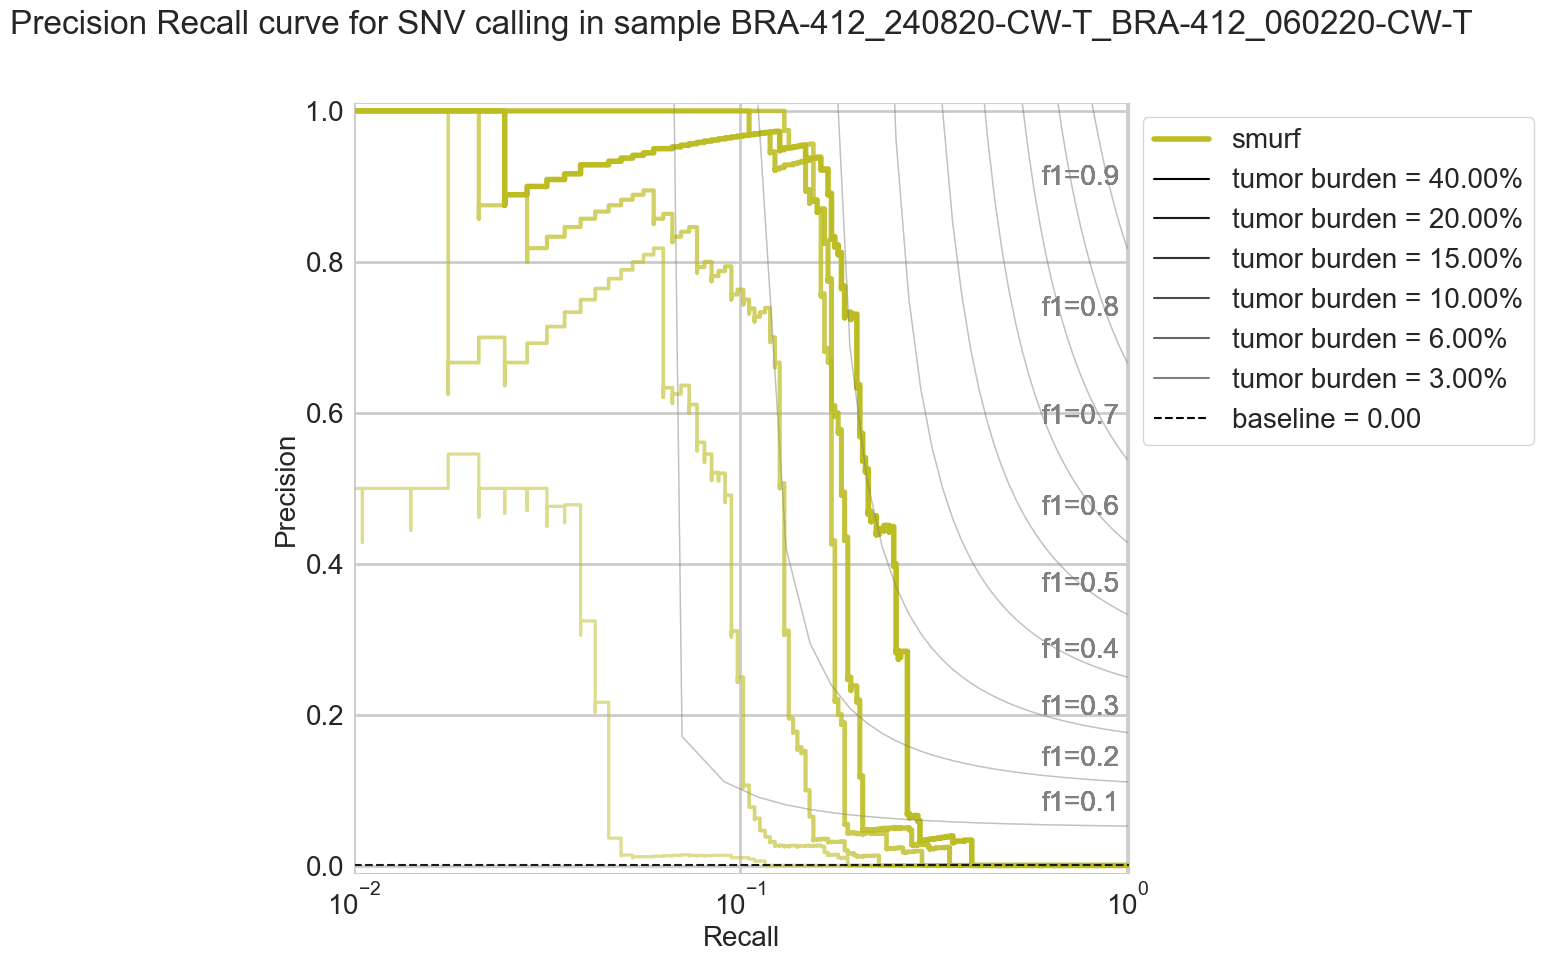

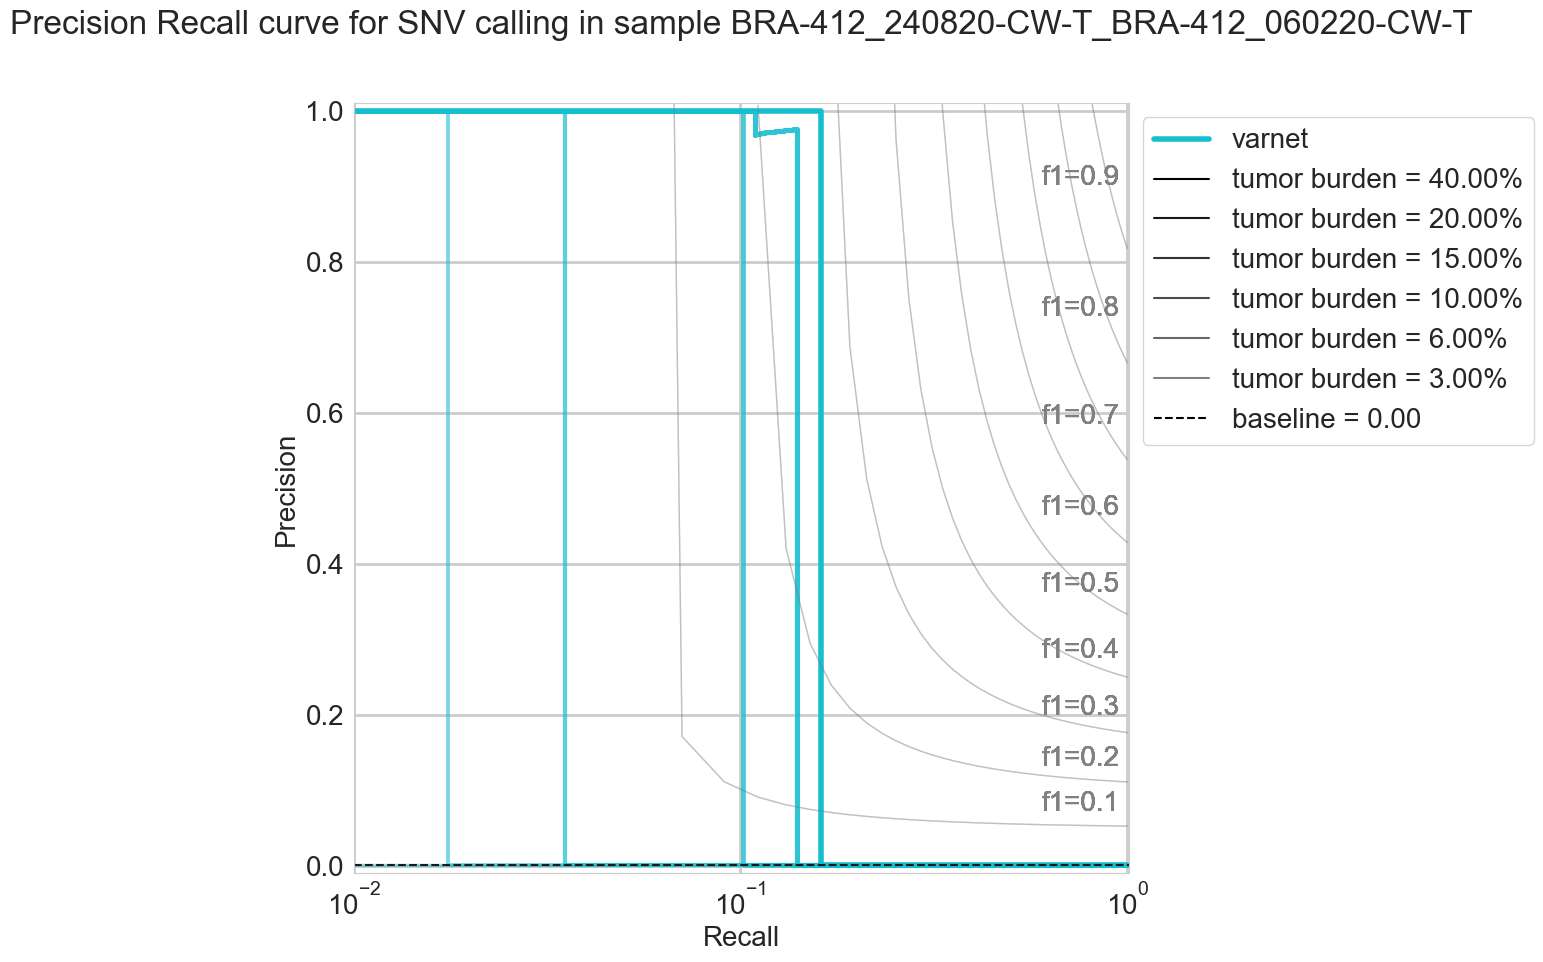

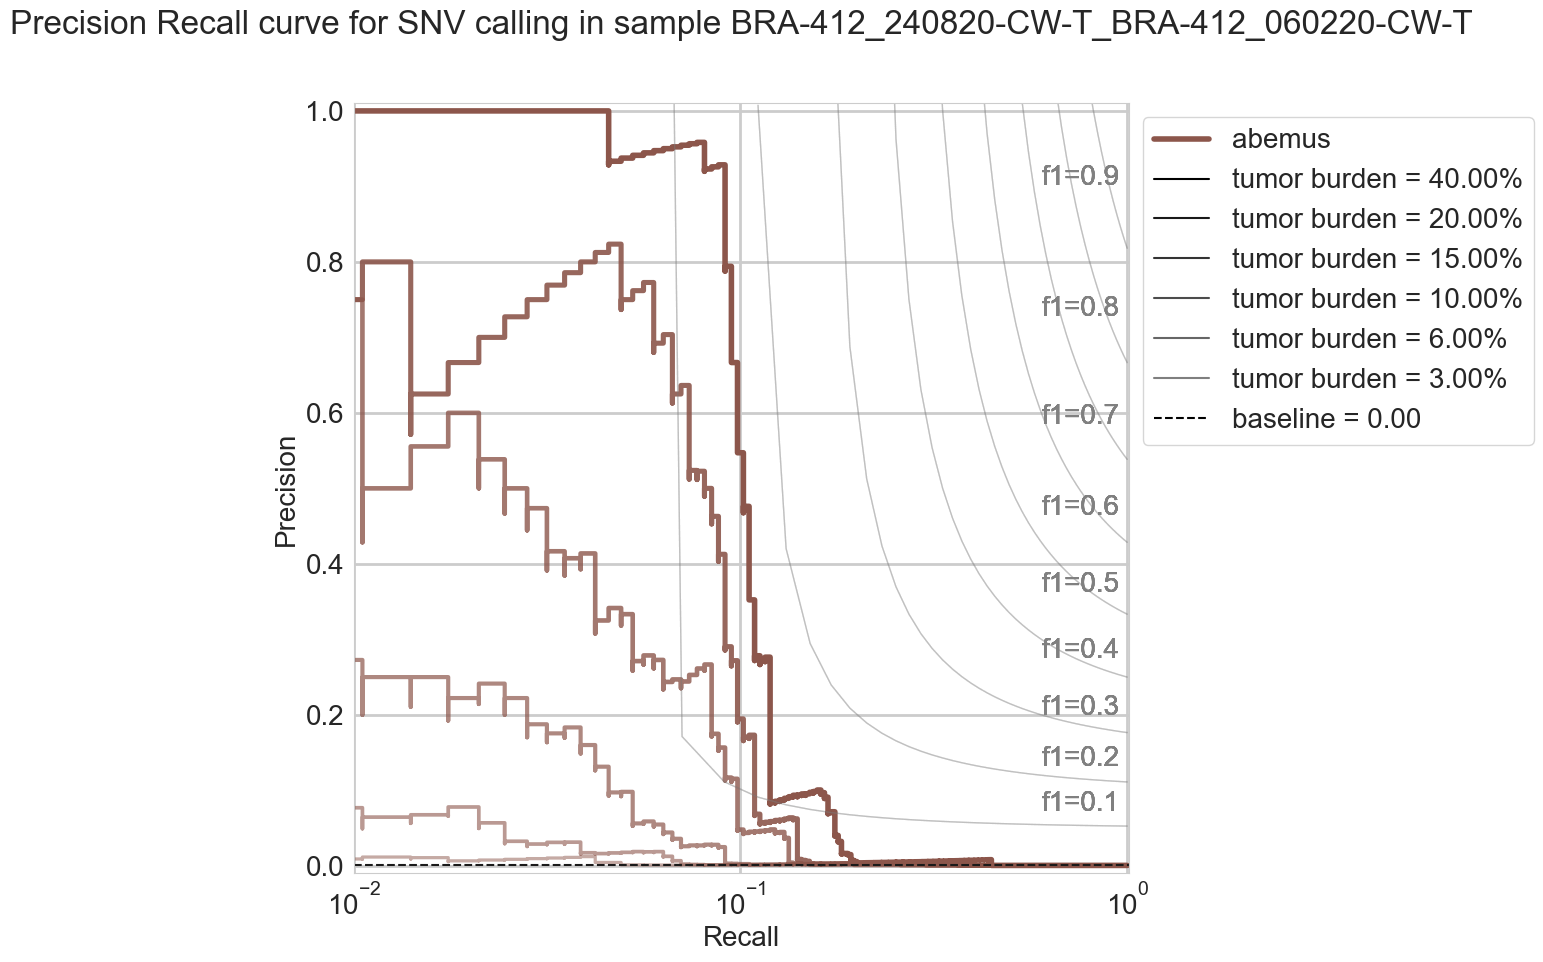

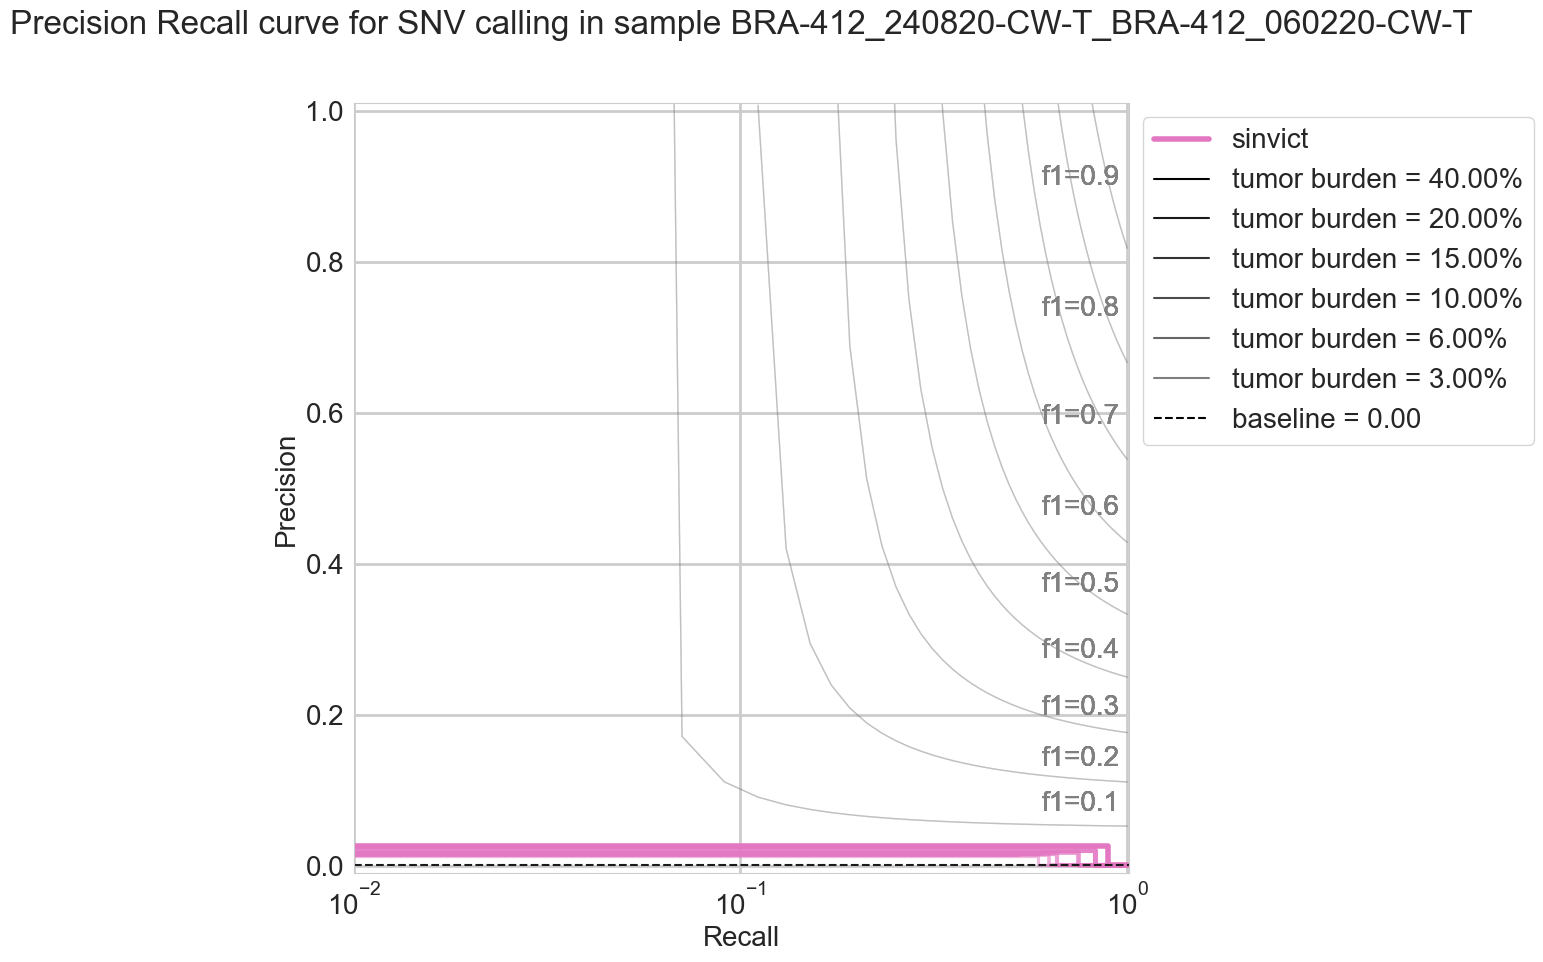

In [151]:
figure_curve_allchr(config, calltablesseries, dilutionseries, mixtureid, xy='pr', ground_truth_method=gtm,
                        refsample=refsample, muttype=muttype.upper(), methods=None, fixedvar=fixedvar, save=True)